In [1]:
from visualizations import * 

from matching import Matcher


from matplotlib import pyplot as plt
plt.style.use('ggplot')

from MAG_network import CitationNetwork
import os 
from matplotlib import pyplot as plt
import pandas as pd
import findspark
import MAGspark
import itertools

import sys

import numpy as np
import scipy
from scipy.stats import ks_2samp

sys.path.insert(0,"/home/laal/MAG/CentralityFairness/Evaluations")

Evaluations/lenskit/util.py:45: NumbaDeprecationWarning: The 'numba.jitclass' decorator has moved to 'numba.experimental.jitclass' to better reflect the experimental nature of the functionality. Please update your imports to accommodate this change and see https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#change-of-jitclass-location for the time frame.
  @jitclass([


In [2]:
mag, spark = MAGspark.get_mag_with_cluster_connection(jobid=44076, memory_per_executor=14000,
                                                      data_folderpath="/home/laal/MAG/DATA/")

['NAME STATE JOBID', 'runlstmd RUNNING 43962', 'ant_bullet RUNNING 43777', 'sparkcluster RUNNING 44076', 'baseline-with-other RUNNING 44071', 'baseline-without-other RUNNING 44070', 'ant_bullet RUNNING 43778', 'train-emb-tweets-concatenated-shuffled1 RUNNING 44083', 'ant_bullet RUNNING 43768', 'ant_bullet RUNNING 43779', 'job-drivers.job RUNNING 44018', 'ant_bullet RUNNING 43781', 'train-gpu RUNNING 44067', 'train-gpu RUNNING 44065', 'train-gpu RUNNING 44064', 'train-gpu RUNNING 44063', 'train-gpu RUNNING 44061', 'train-gpu RUNNING 44060', 'jupyter RUNNING 43977', '1.testTrain.0 RUNNING 44091', '1.testTrain.1 RUNNING 44092', '']


In [3]:
def compute_ks_test(mag, centrality_df, fos_id, base_filepath="/home/laal/MAG/DATA"):
    
    centrality_df[['AuthorId', 'Gender']].to_csv(base_filepath + "/CentralityAuthors.txt", header=False,index=False, sep="\t")
    
    mag.streams['CentralityAuthors'] = ('CentralityAuthors.txt', ['AuthorId:long', 'Gender:int'])
    
    inter_event = mag.getDataframe('InterEventPublications')
    cent_authors = mag.getDataframe('CentralityAuthors')
    
    query = """
        SELECT iep.AuthorId, ca.Gender, iep.DateDiff 
        FROM InterEventPublications  iep
        INNER JOIN CentralityAuthors ca ON iep.AuthorId = ca.AuthorId
        WHERE FieldOfStudyId = {} AND PrevPaperId != CurrentPaperId
    """.format(fos_id)
    
    
    datediffs = mag.query_sql(query).toPandas()
    women_interevent = datediffs.query("Gender == 0")['DateDiff']
    men_interevent = datediffs.query("Gender == 1")['DateDiff']
    
    ks_test = ks_2samp(women_interevent.values, men_interevent.values)
    
    return datediffs, ks_test


def plot_inter_event_cdf(datediffs, ks_test, field_name, filepath=None):
    labelsize = 20
    women_interevent = datediffs.query("Gender == 0")['DateDiff']
    men_interevent = datediffs.query("Gender == 1")['DateDiff']
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))

    women_interevent.hist(cumulative=True, density=1, bins=2000, histtype='step', 
                          linewidth=3, color="#6fc9f2", label="Women")

    men_interevent.hist(cumulative=True, density=1, bins=2000, histtype='step', linewidth=3, 
                        label="Men", color="#bd8aff")

    plt.xlim(-100, 2500)
    plt.ylim(0.0, 1.05)

    title = r"$\bf{" +  field_name.replace(" ", "\ ")  + "}$" +  \
    ":\nCDF: Number of days between consequtive publishing dates"
    title += "\n KS statistic: {0:.3f}".format(ks_test.statistic) + ", p-value: {0:.3f}".format(ks_test.pvalue)
    
    plt.title(title, color='#363534')
    plt.xlabel('Number of days', color='#363534', fontsize=labelsize)
    plt.ylabel('Cumulative probability', color='#363534', fontsize=labelsize)
    
    ax.tick_params(axis='y', labelsize=labelsize)
    ax.tick_params(axis='x', labelsize=labelsize)
    
    plt.legend(loc="right")
    
    if filepath is not None:
        plt.savefig(filepath)
        
    plt.show()
    
    

def plot_centrality_correlations(field_name, matched_data, filename=None):

    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,8), sharex=False, sharey=False)
    axs = list(axs.flatten())
    
    labelsize = 12
    idx = 0
    
    matched_data['MAG Rank'] = 1 / matched_data['Rank'] 
    
    CENTRALITIES = ['PageRank', 'PageRank05', 'InDegreeStrength', 'MAG Rank']
    
    for cent1, cent2 in itertools.combinations(CENTRALITIES, r=2):
    
        corr = scipy.stats.pearsonr(matched_data[cent1], matched_data[cent2])
        axs[idx].scatter(x=matched_data[cent1], y=matched_data[cent2], color="#ff8c00", alpha=0.3)
        axs[idx].set_title("{} vs. {}".format( cent1, cent2 ) + "\n Corr = {0:.3f}, p-value=".format(corr[0]) + "{0:.3f}".format(corr[1]),
                          color='#363534')
        axs[idx].set_ylabel(cent2, fontsize=labelsize, color='#363534')
        axs[idx].set_xlabel(cent1, fontsize=labelsize, color='#363534')
        
        axs[idx].tick_params(axis='y', labelsize=labelsize)
        axs[idx].tick_params(axis='x', labelsize=labelsize, rotation=45)
        
        idx += 1


    plt.suptitle('Centrality correlations for matched population: ' + r"$\bf{" +  field_name.replace(" ", "\ ")  + "}$", 
                 fontsize=16, color='#363534')
    plt.tight_layout()
    
    if filename is not None:
        plt.savefig(filename)
    plt.show()

--------------------------------STARTING VIZ ON ECONOMICS-----------------------------


gender counts before query:

1    304369
0    111367
Name: Gender, dtype: int64
Men with more than 1 paper:  (144398, 12)
Women with more than 1 paper:  (51698, 12)
Number of men before removing NaN-affiliation bin: 144398
Number of women before removing NaN-affiliation bin: 51698
Number of men after removing NaN-affiliation bin: 115100
Number of women after removing NaN-affiliation bin: 42355


/home/laal/MAG/CentralityFairness/visualizations.py:221: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(xticks, fontsize=labelsize)
/home/laal/MAG/CentralityFairness/visualizations.py:230: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_xticklabels(xticks, fontsize=labelsize)


Full data median: 98047.5
Random data median: 102285.0
Matched data median: 104163.5


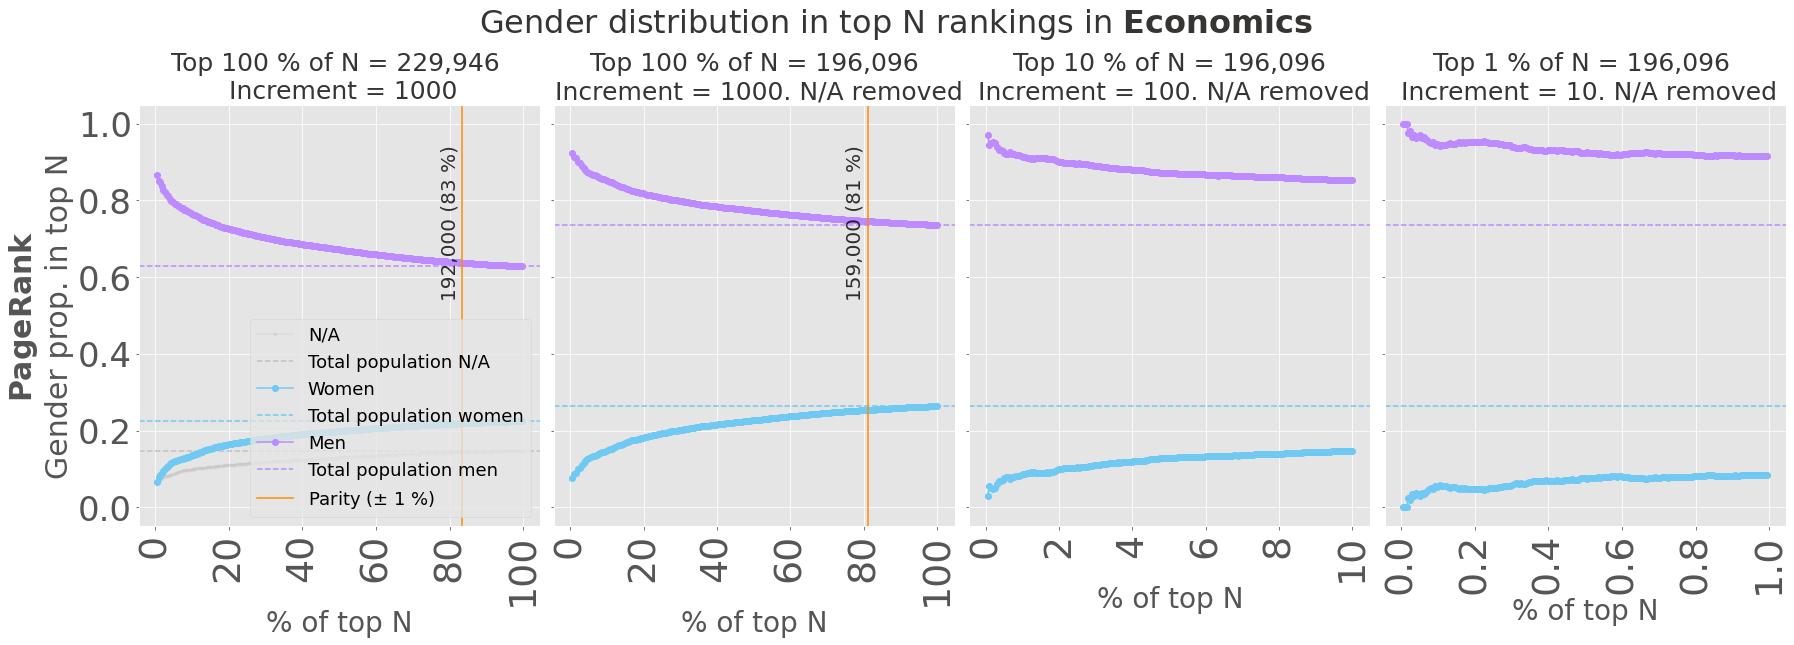

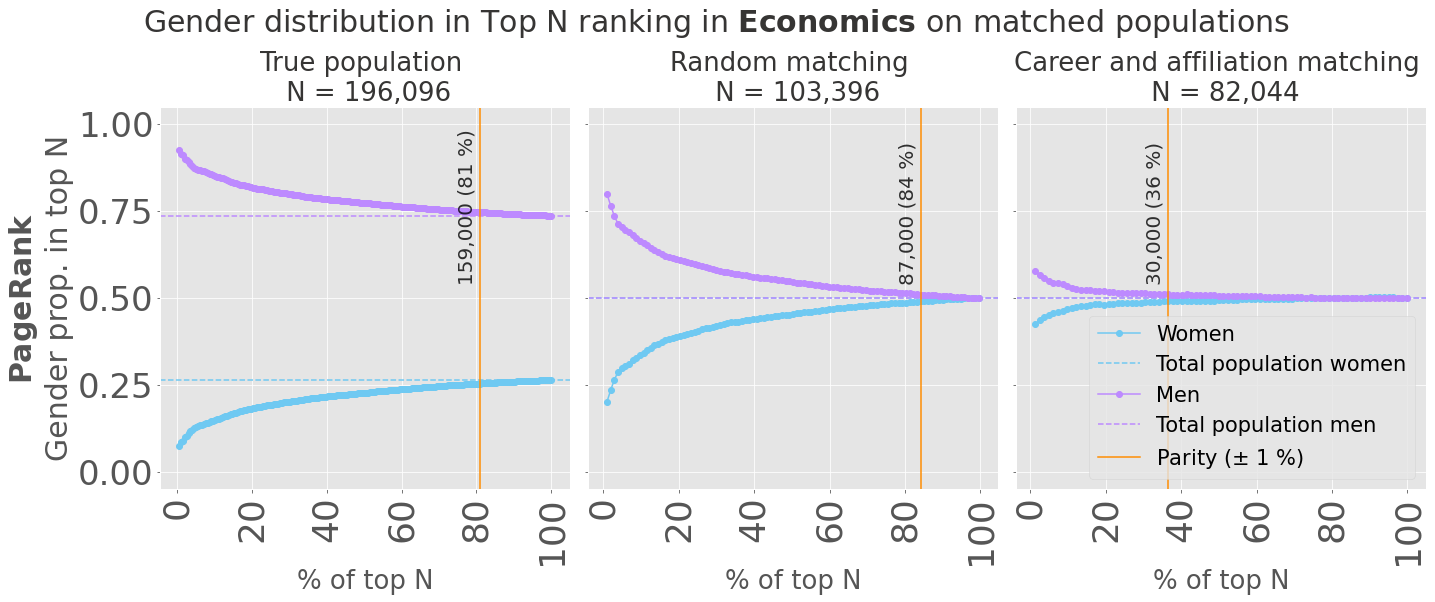

/home/laal/MAG/CentralityFairness/visualizations.py:221: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(xticks, fontsize=labelsize)
/home/laal/MAG/CentralityFairness/visualizations.py:230: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_xticklabels(xticks, fontsize=labelsize)


Full data median: 98047.5
Random data median: 101908.5
Matched data median: 102711.0


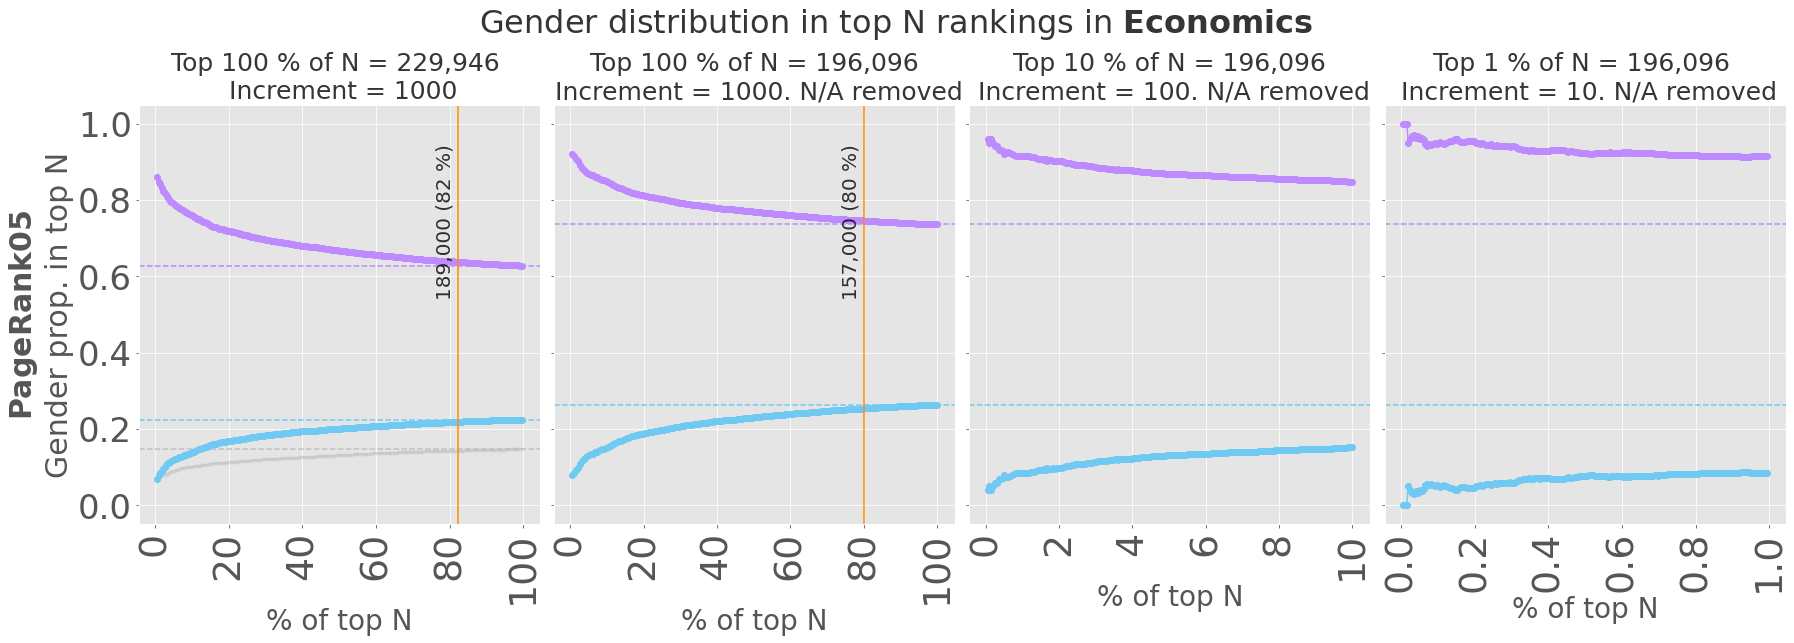

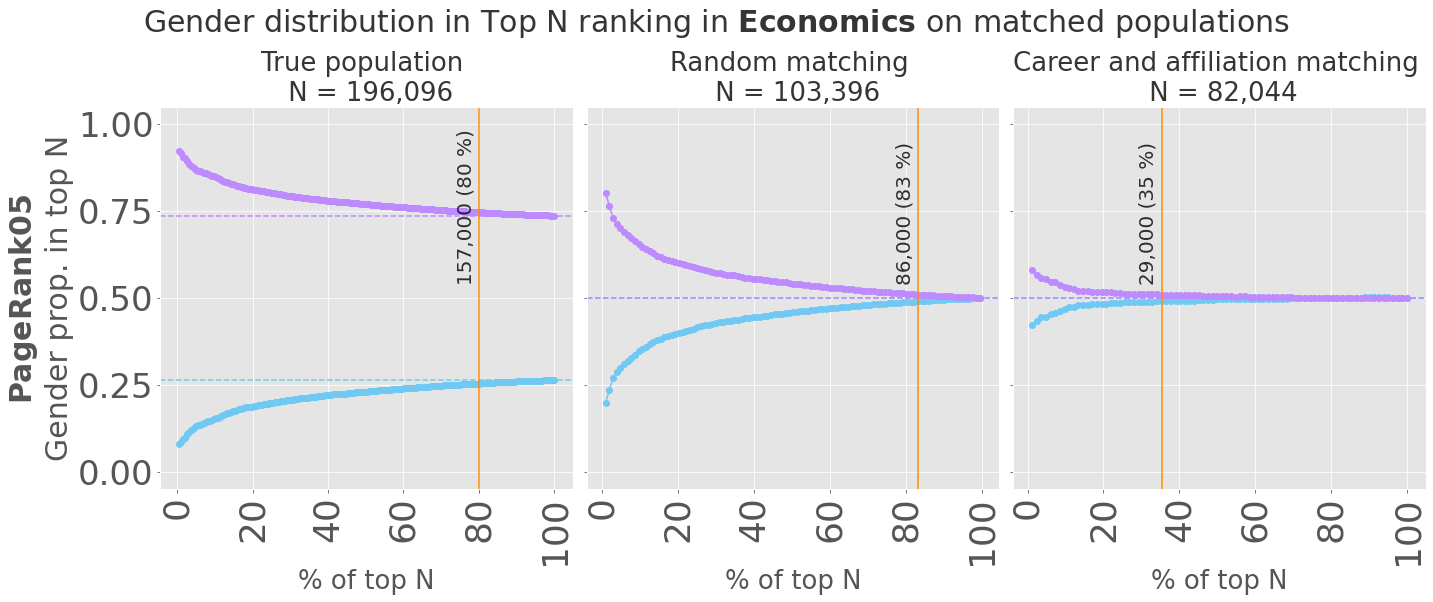

/home/laal/MAG/CentralityFairness/visualizations.py:221: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(xticks, fontsize=labelsize)
/home/laal/MAG/CentralityFairness/visualizations.py:230: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_xticklabels(xticks, fontsize=labelsize)


Full data median: 98047.5
Random data median: 101441.5
Matched data median: 98729.5


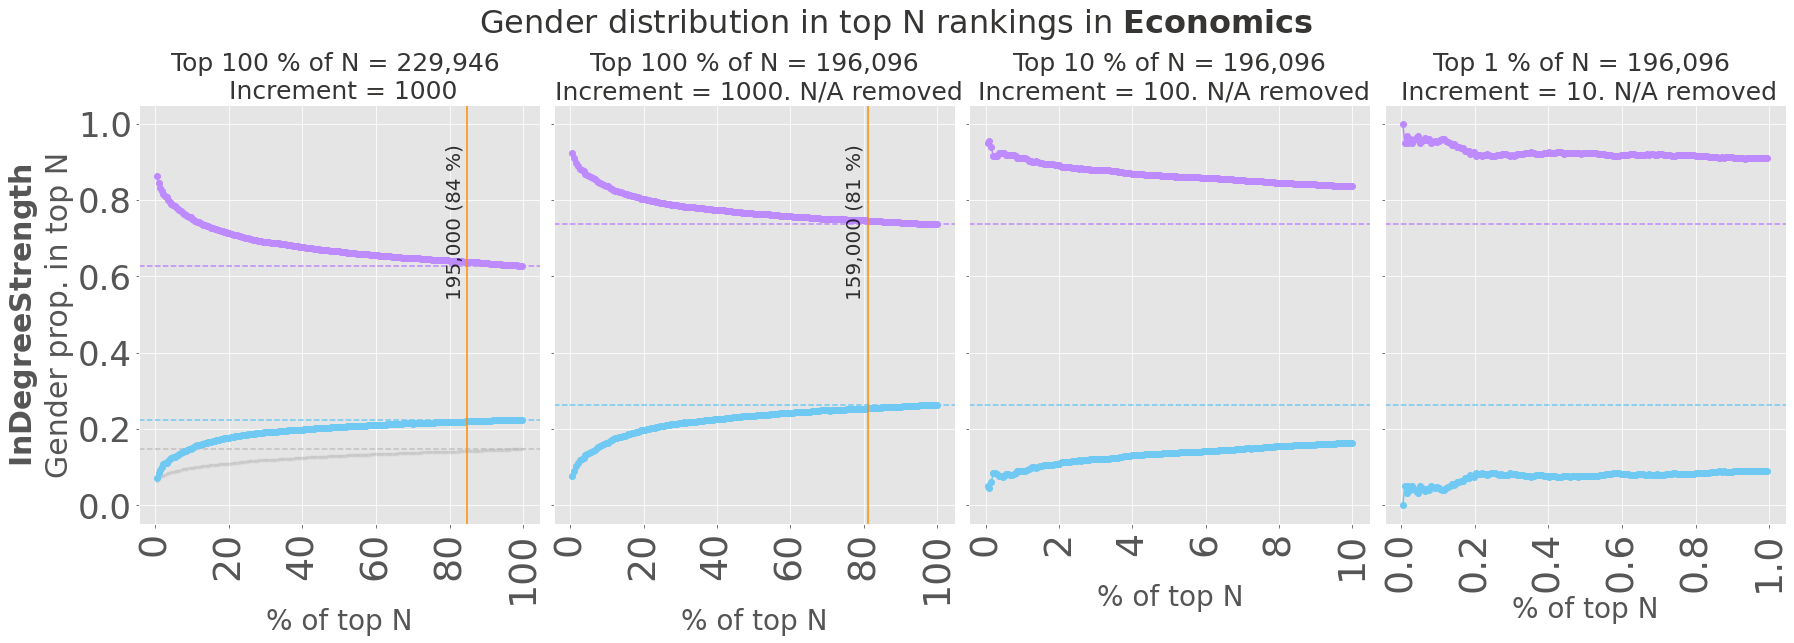

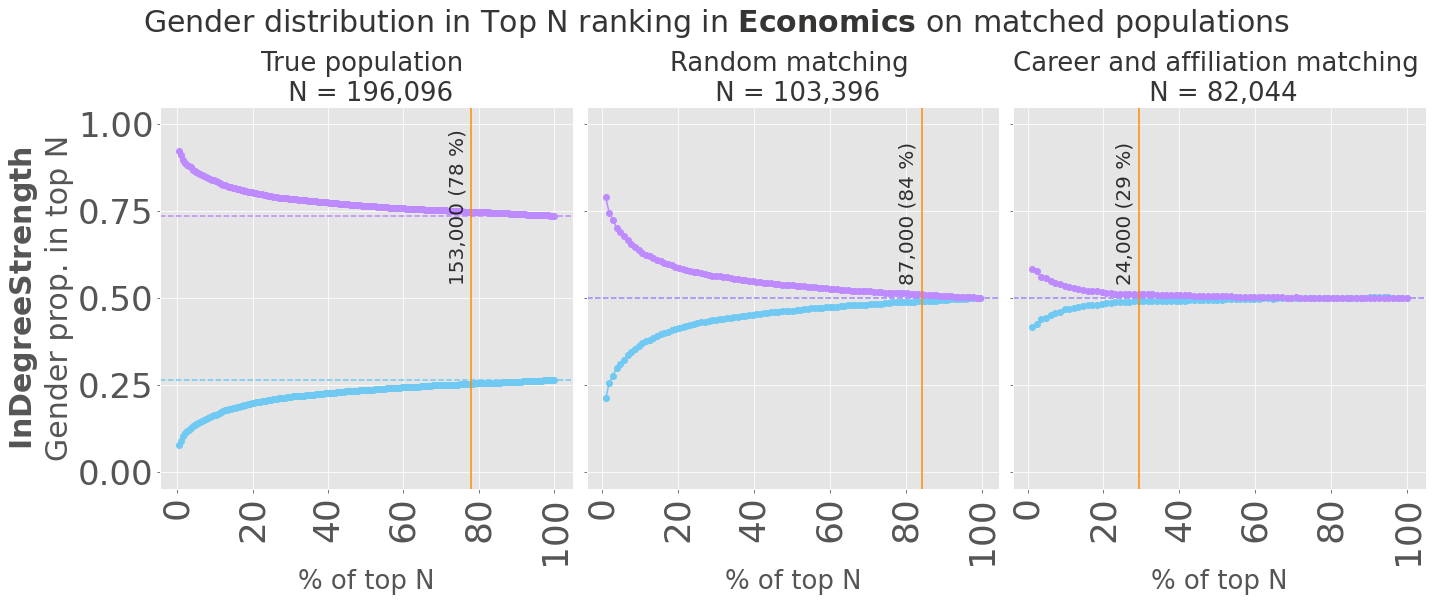

/home/laal/MAG/CentralityFairness/visualizations.py:221: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(xticks, fontsize=labelsize)
/home/laal/MAG/CentralityFairness/visualizations.py:230: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_xticklabels(xticks, fontsize=labelsize)


Full data median: 98047.5
Random data median: 100529.5
Matched data median: 94236.0


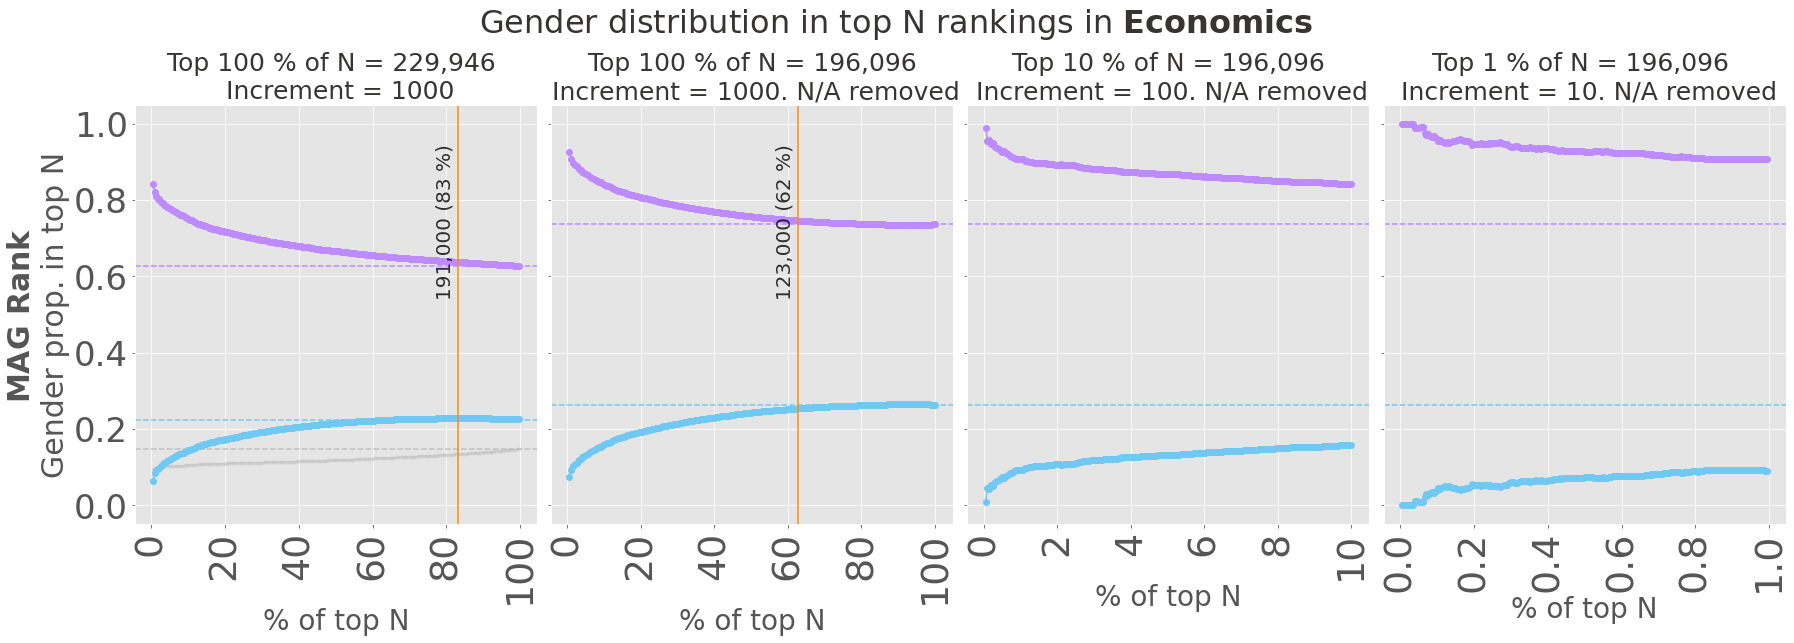

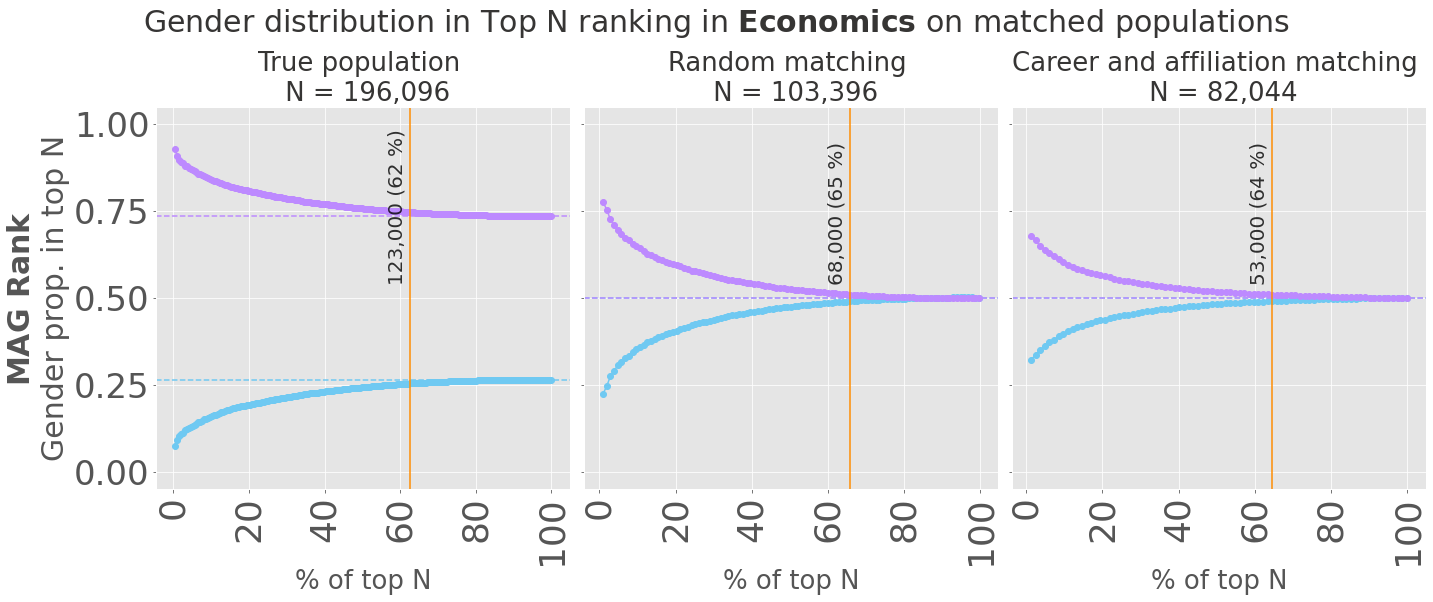

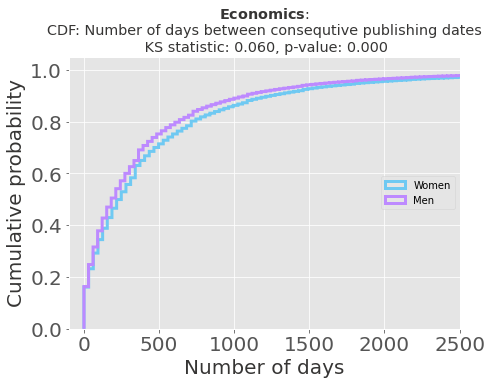

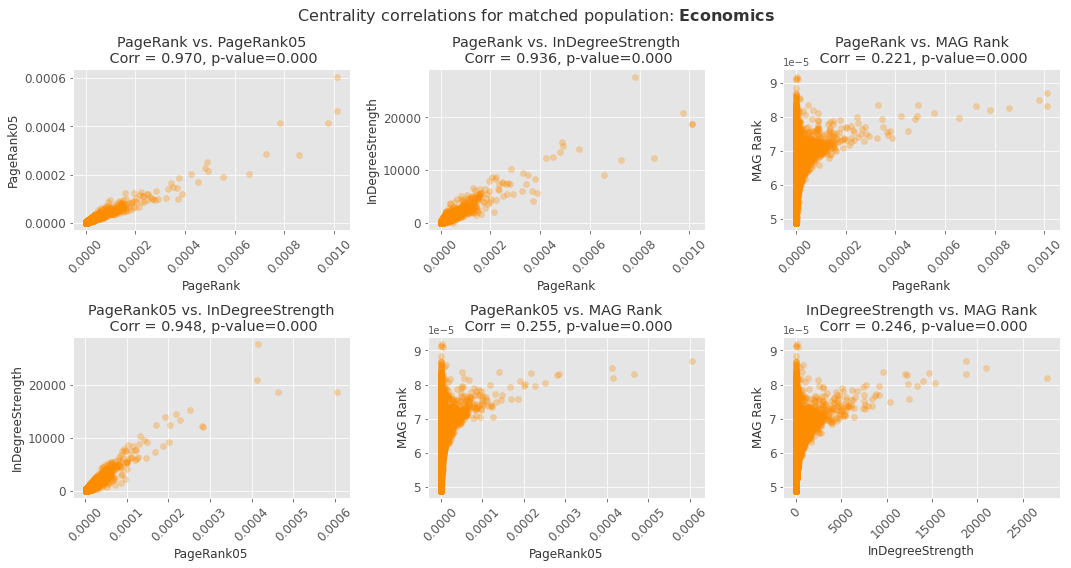

--------------------------------STARTING VIZ ON PSYCHOLOGY-----------------------------


gender counts before query:

0    814668
1    808992
Name: Gender, dtype: int64
Men with more than 1 paper:  (382847, 12)
Women with more than 1 paper:  (380440, 12)
Number of men before removing NaN-affiliation bin: 382847
Number of women before removing NaN-affiliation bin: 380440
Number of men after removing NaN-affiliation bin: 306191
Number of women after removing NaN-affiliation bin: 316480


/home/laal/MAG/CentralityFairness/visualizations.py:221: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(xticks, fontsize=labelsize)
/home/laal/MAG/CentralityFairness/visualizations.py:230: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_xticklabels(xticks, fontsize=labelsize)


Full data median: 381643.0
Random data median: 381711.5
Matched data median: 374091.0


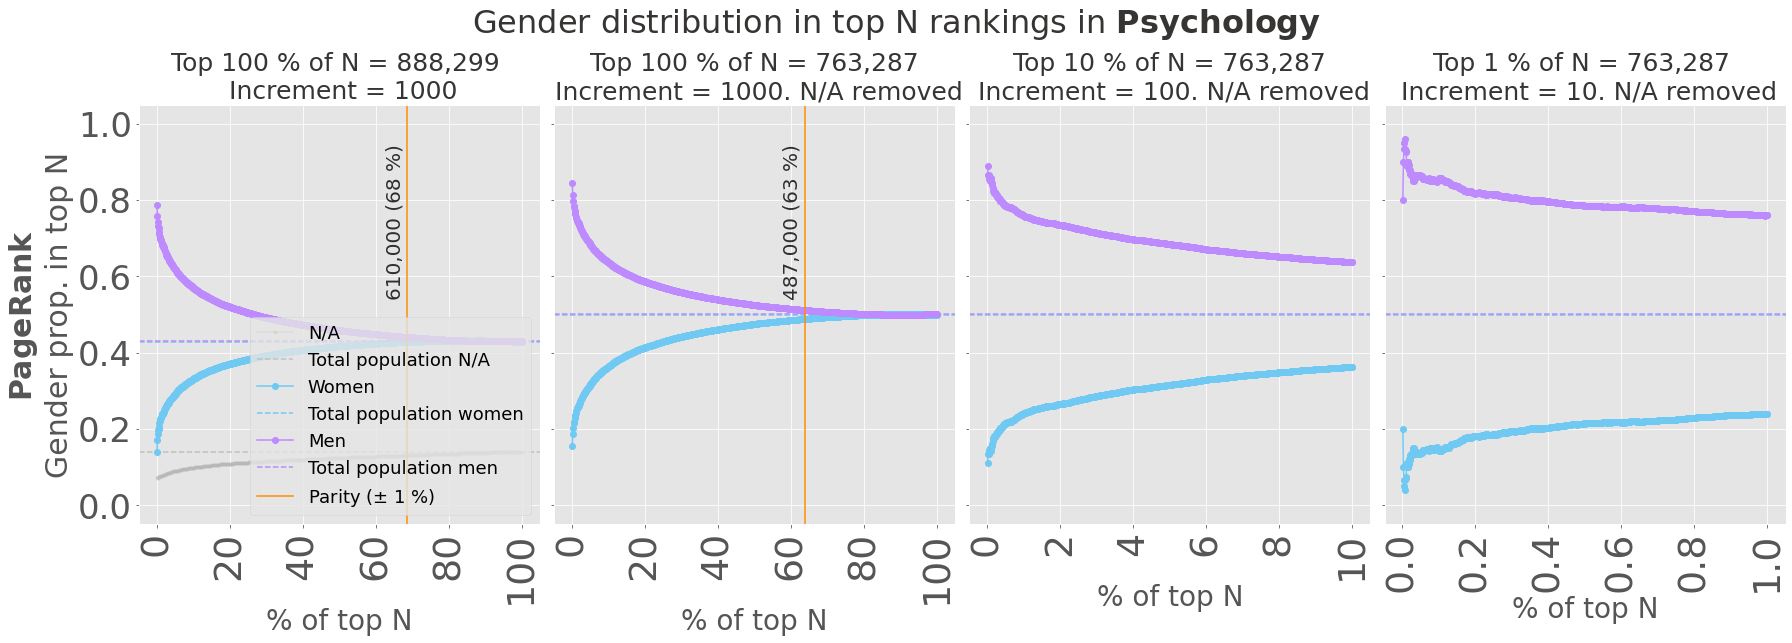

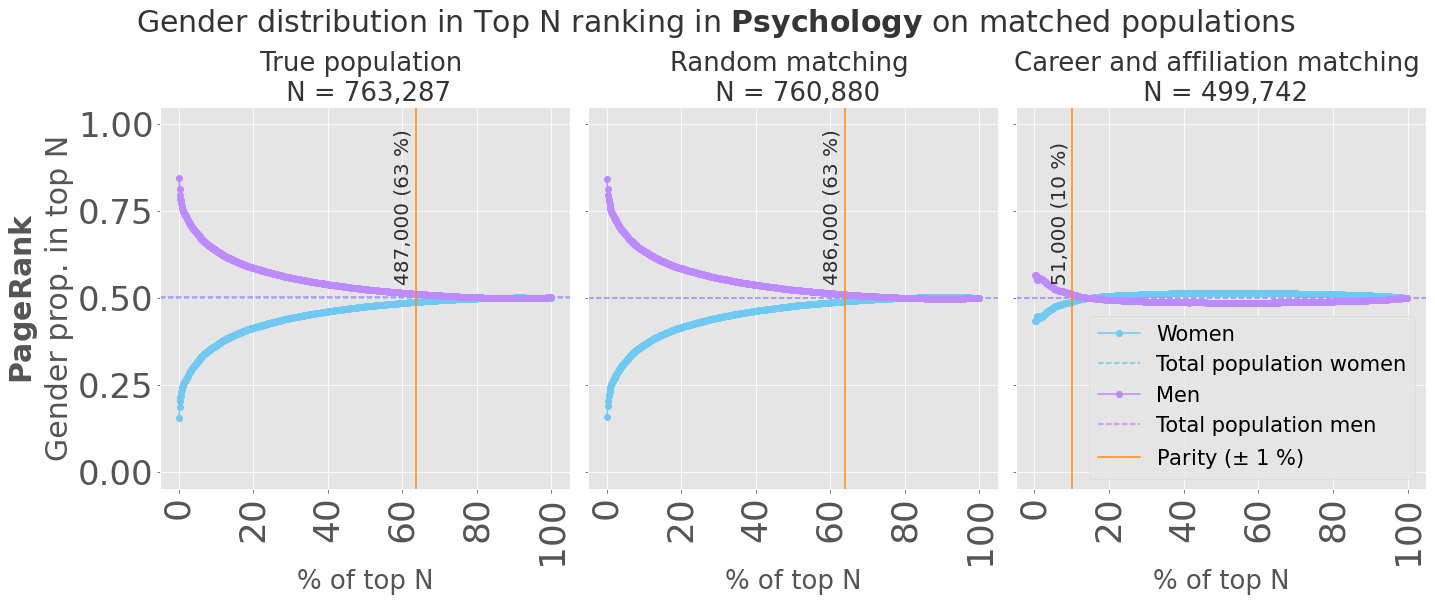

/home/laal/MAG/CentralityFairness/visualizations.py:221: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(xticks, fontsize=labelsize)
/home/laal/MAG/CentralityFairness/visualizations.py:230: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_xticklabels(xticks, fontsize=labelsize)


Full data median: 381643.0
Random data median: 381694.5
Matched data median: 370926.0


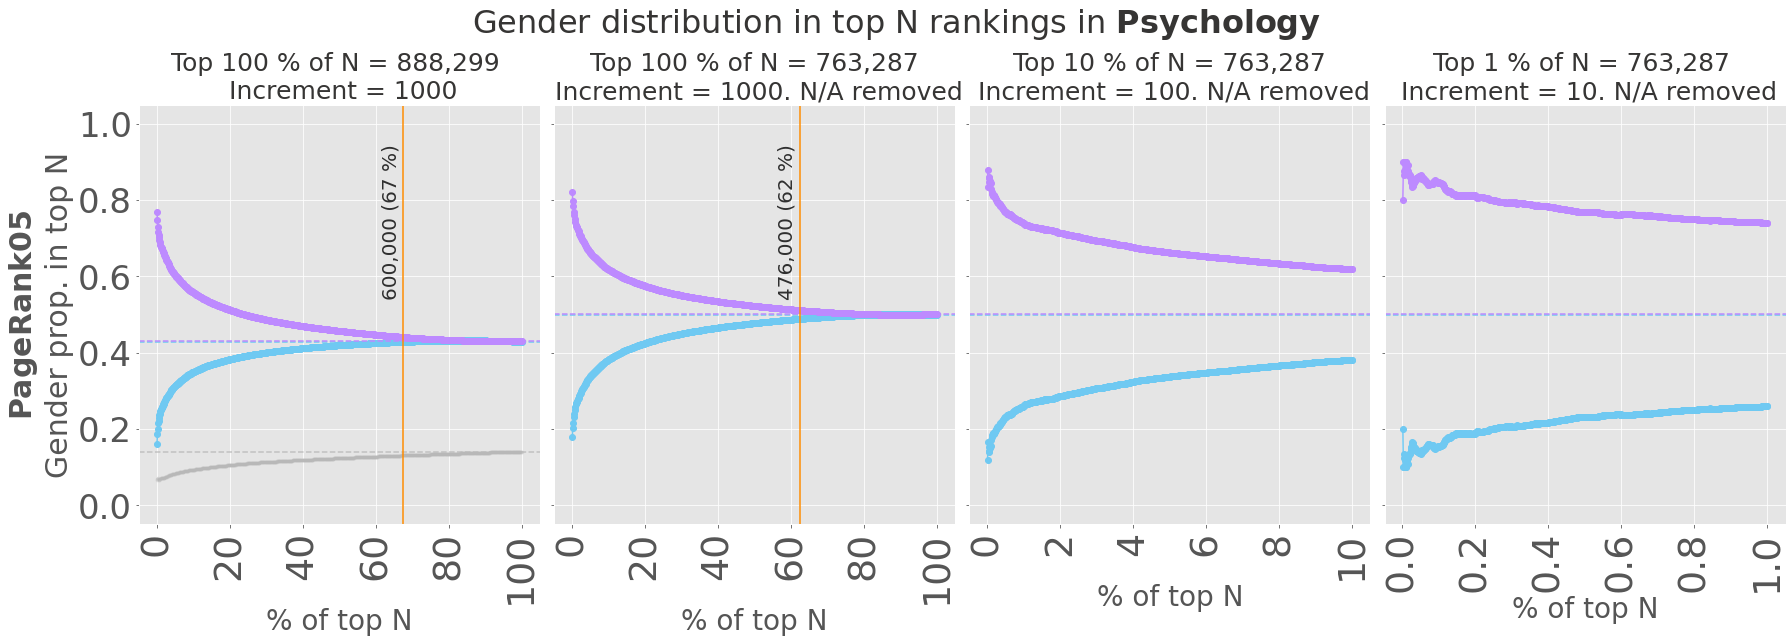

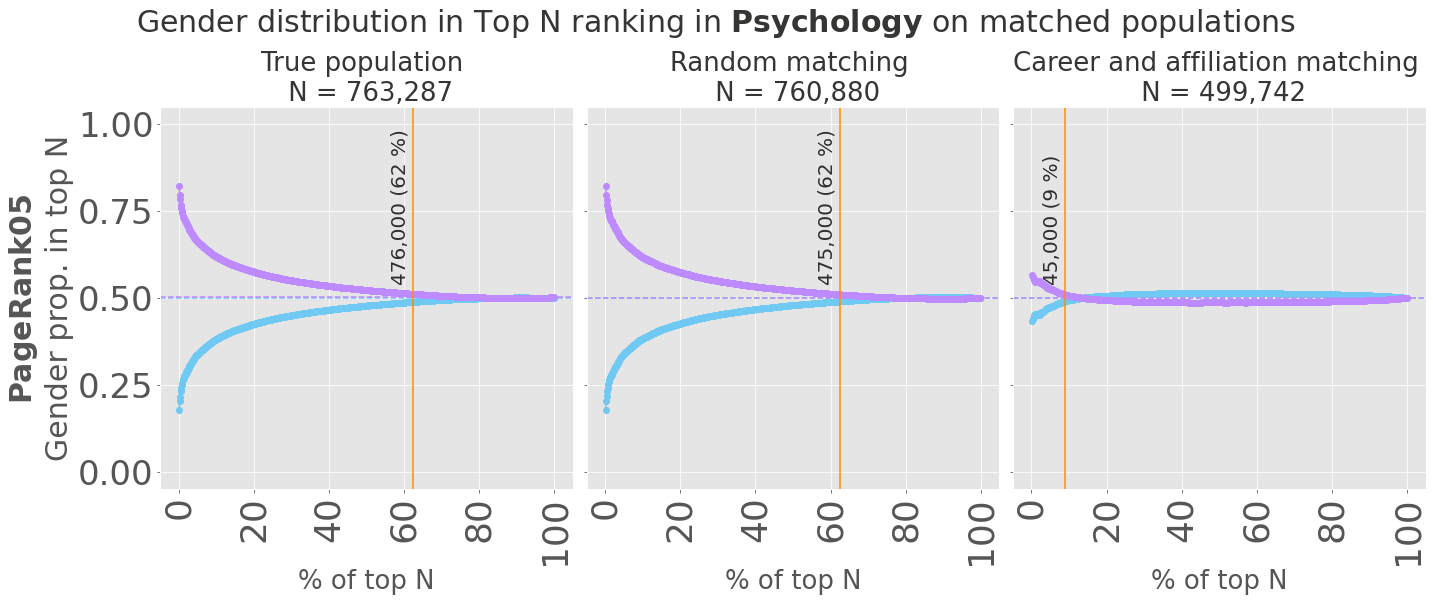

/home/laal/MAG/CentralityFairness/visualizations.py:221: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(xticks, fontsize=labelsize)
/home/laal/MAG/CentralityFairness/visualizations.py:230: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_xticklabels(xticks, fontsize=labelsize)


Full data median: 381643.0
Random data median: 381641.5
Matched data median: 360969.0


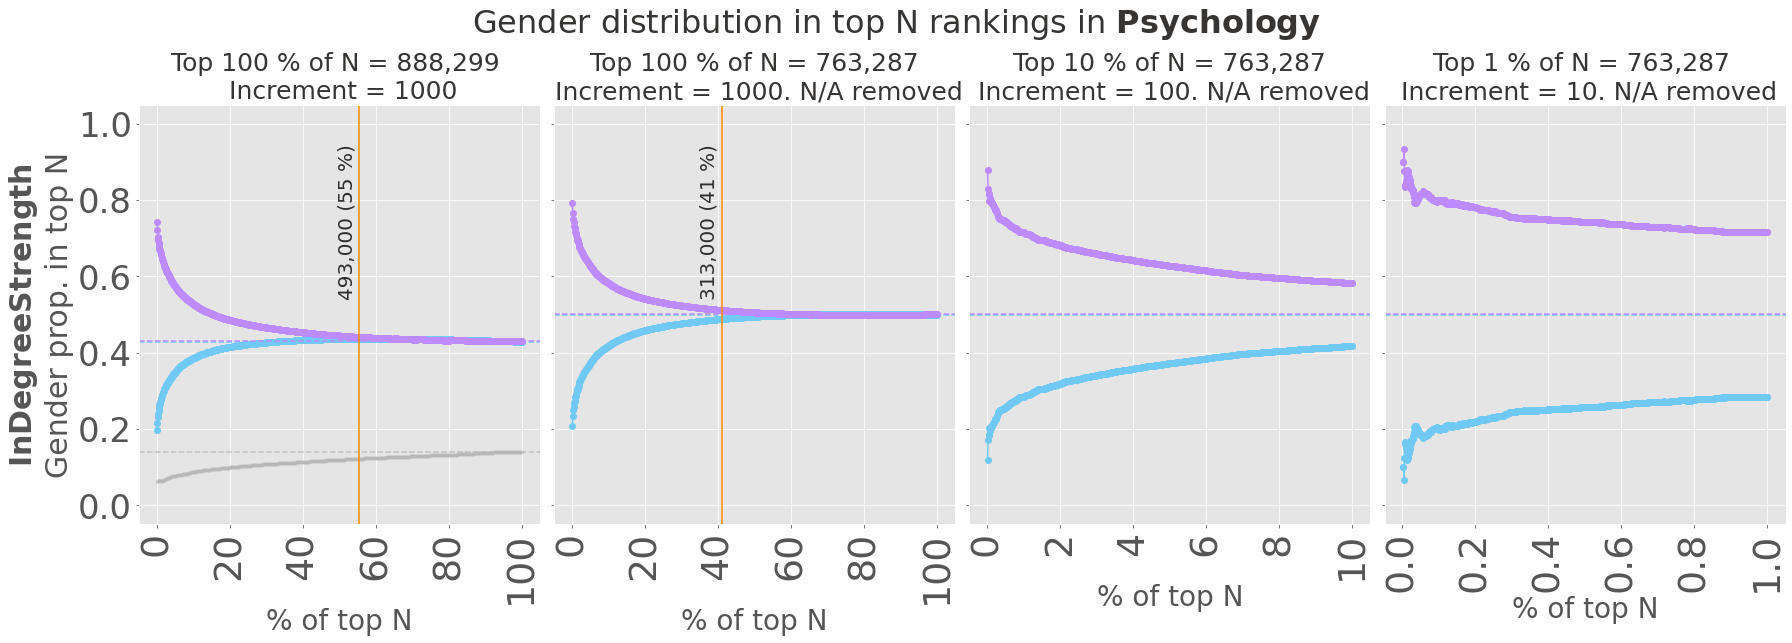

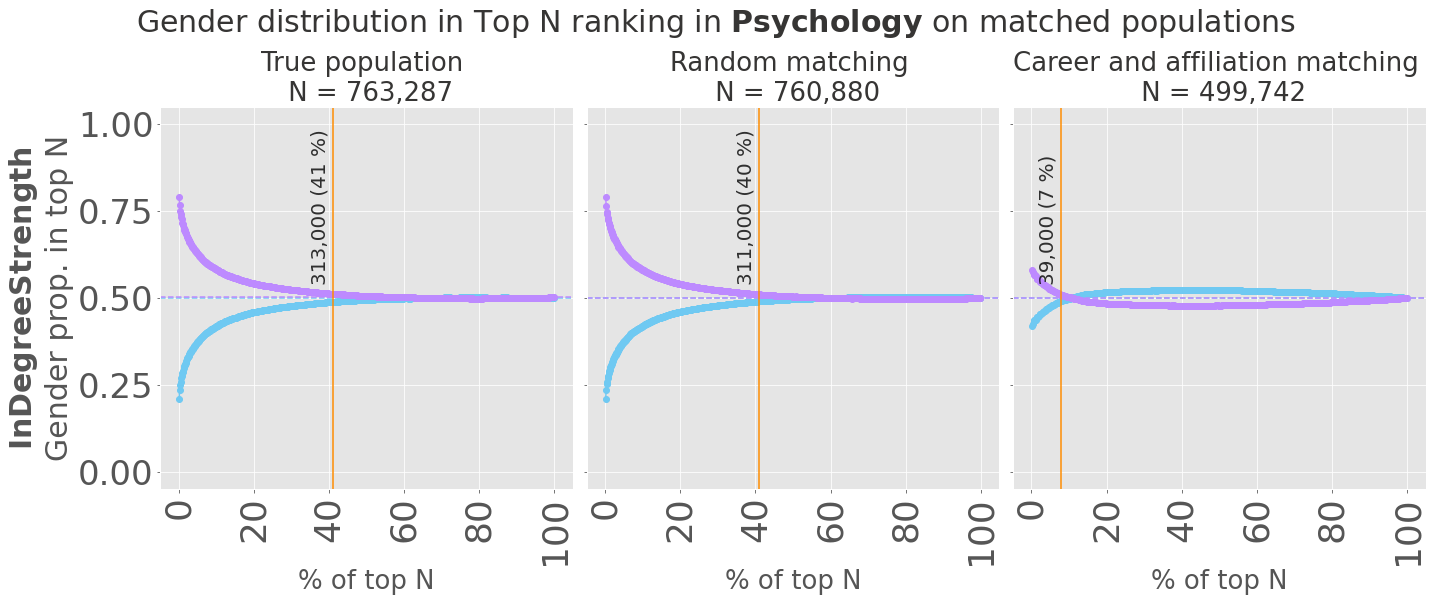

/home/laal/MAG/CentralityFairness/visualizations.py:221: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(xticks, fontsize=labelsize)
/home/laal/MAG/CentralityFairness/visualizations.py:230: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_xticklabels(xticks, fontsize=labelsize)


Full data median: 381643.0
Random data median: 381825.5
Matched data median: 339054.5


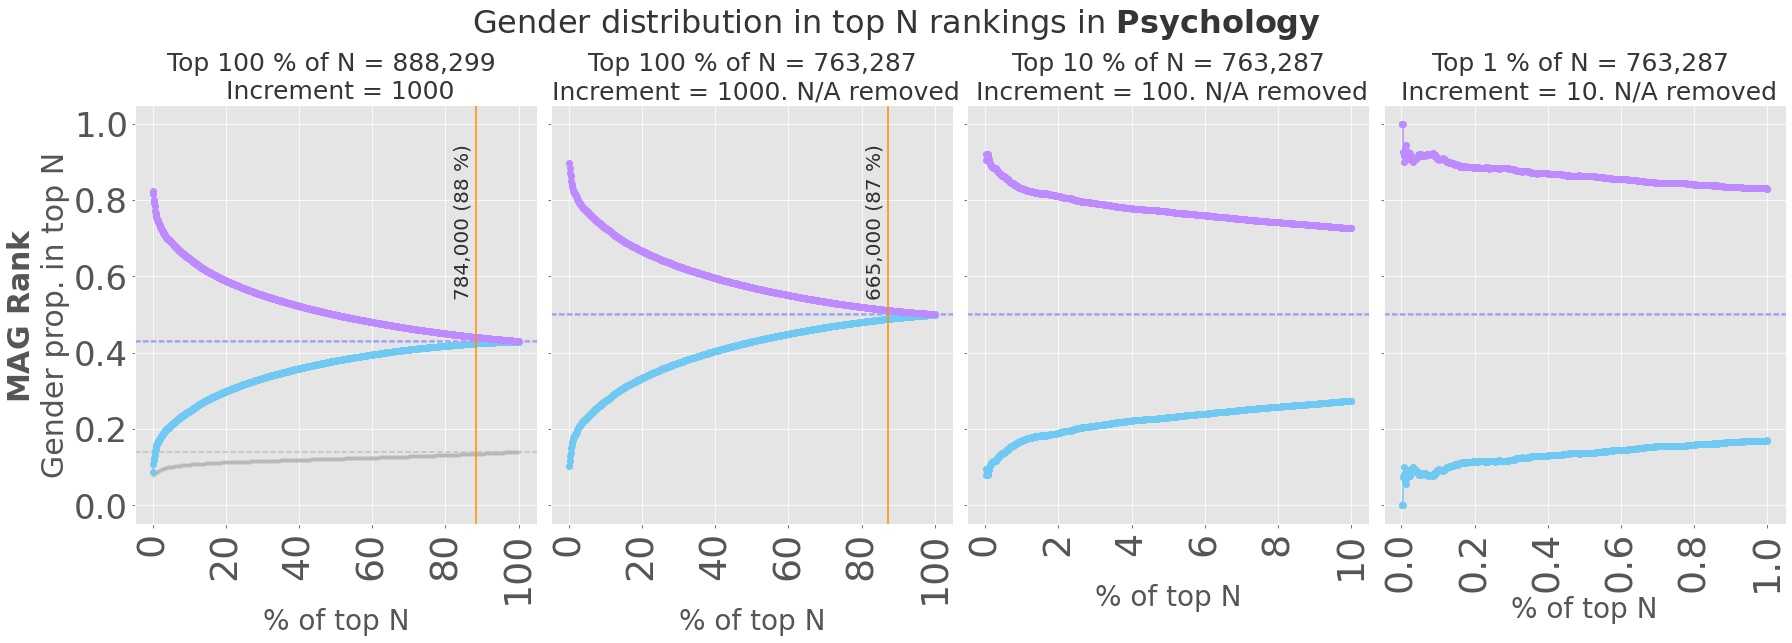

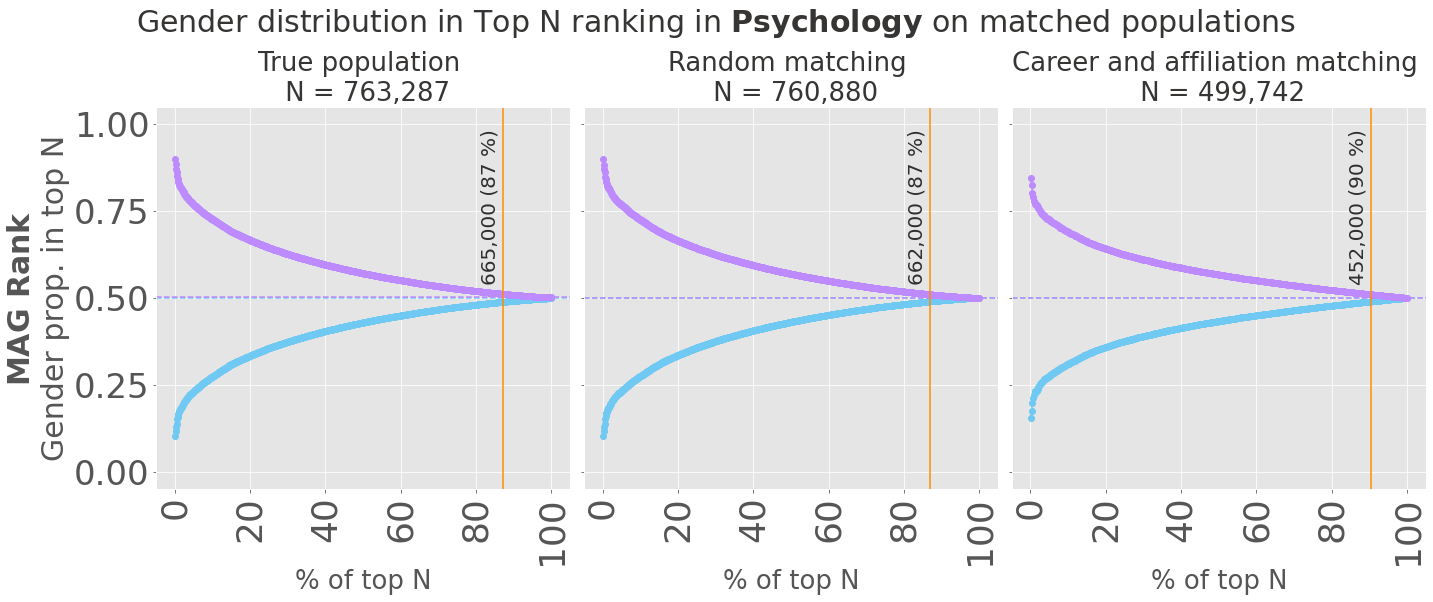

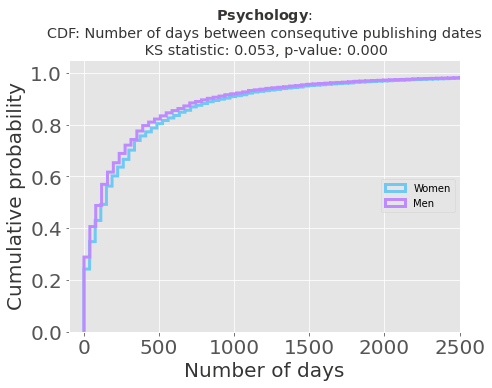

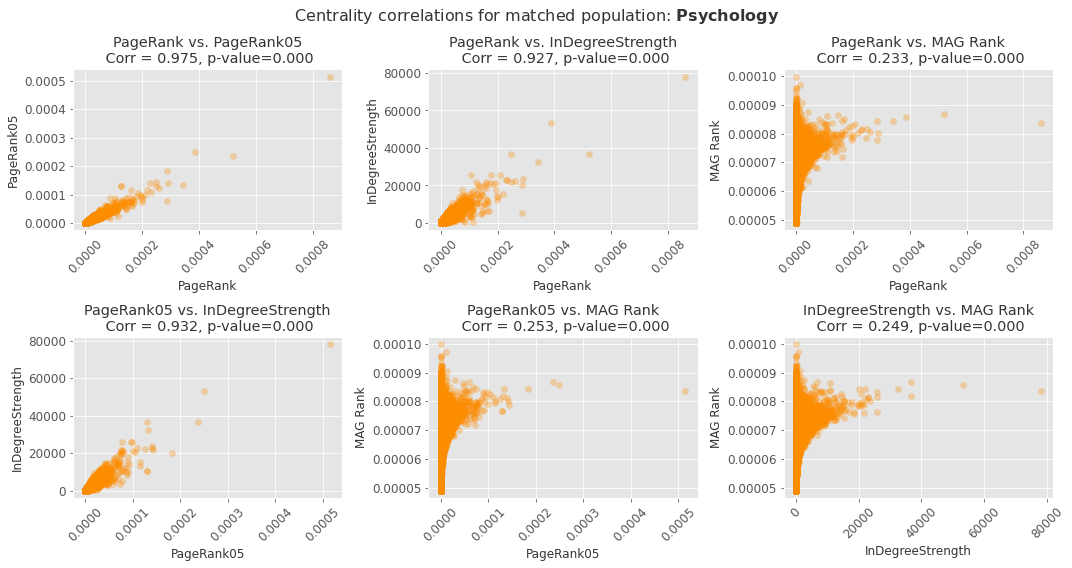

--------------------------------STARTING VIZ ON MATHEMATICS-----------------------------


gender counts before query:

1    753573
0    215664
Name: Gender, dtype: int64
Men with more than 1 paper:  (372092, 12)
Women with more than 1 paper:  (96644, 12)
Number of men before removing NaN-affiliation bin: 372092
Number of women before removing NaN-affiliation bin: 96644
Number of men after removing NaN-affiliation bin: 310905
Number of women after removing NaN-affiliation bin: 82769


/home/laal/MAG/CentralityFairness/visualizations.py:221: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(xticks, fontsize=labelsize)
/home/laal/MAG/CentralityFairness/visualizations.py:230: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_xticklabels(xticks, fontsize=labelsize)


Full data median: 234367.5
Random data median: 247372.5
Matched data median: 259051.5


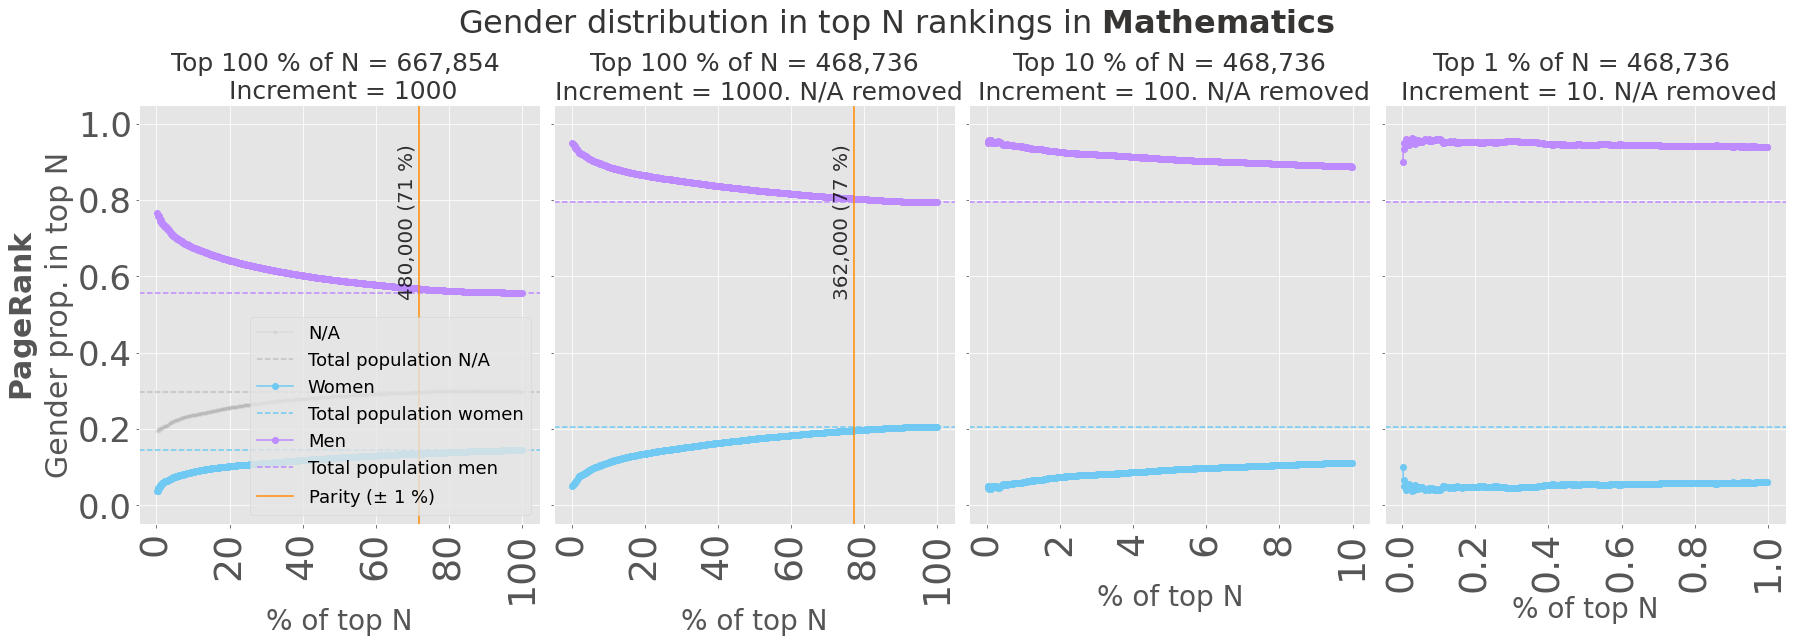

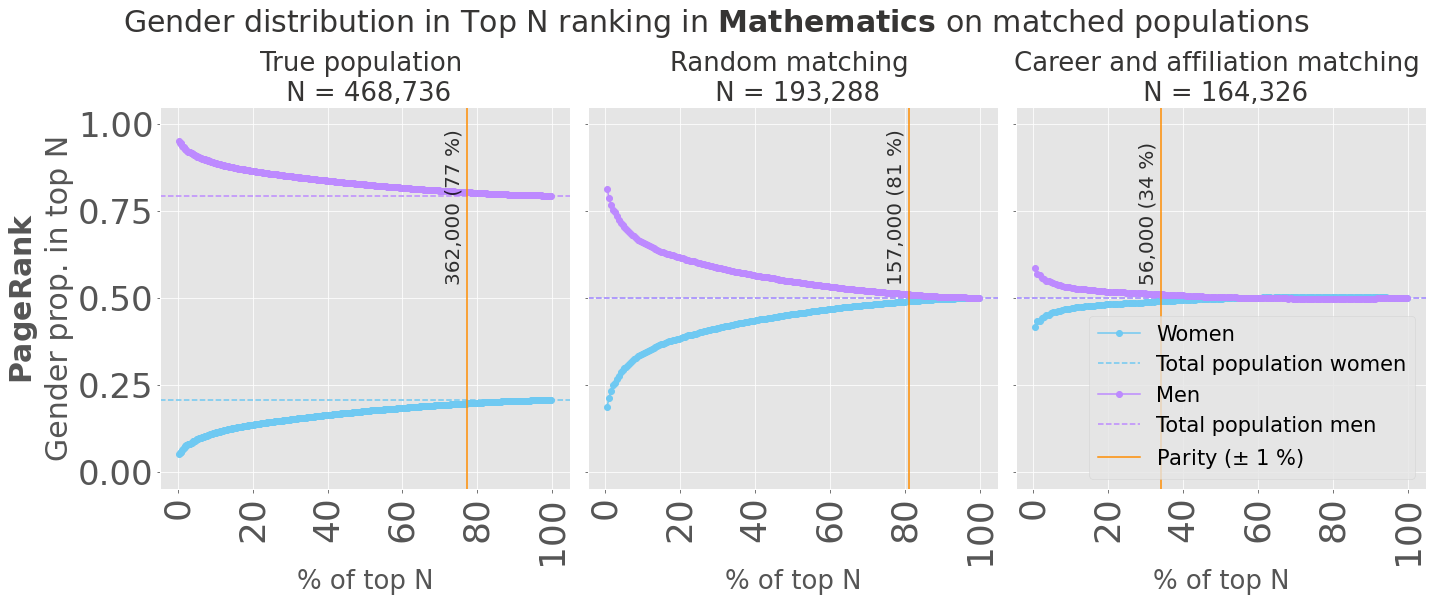

/home/laal/MAG/CentralityFairness/visualizations.py:221: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(xticks, fontsize=labelsize)
/home/laal/MAG/CentralityFairness/visualizations.py:230: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_xticklabels(xticks, fontsize=labelsize)


Full data median: 234367.5
Random data median: 247016.5
Matched data median: 257837.0


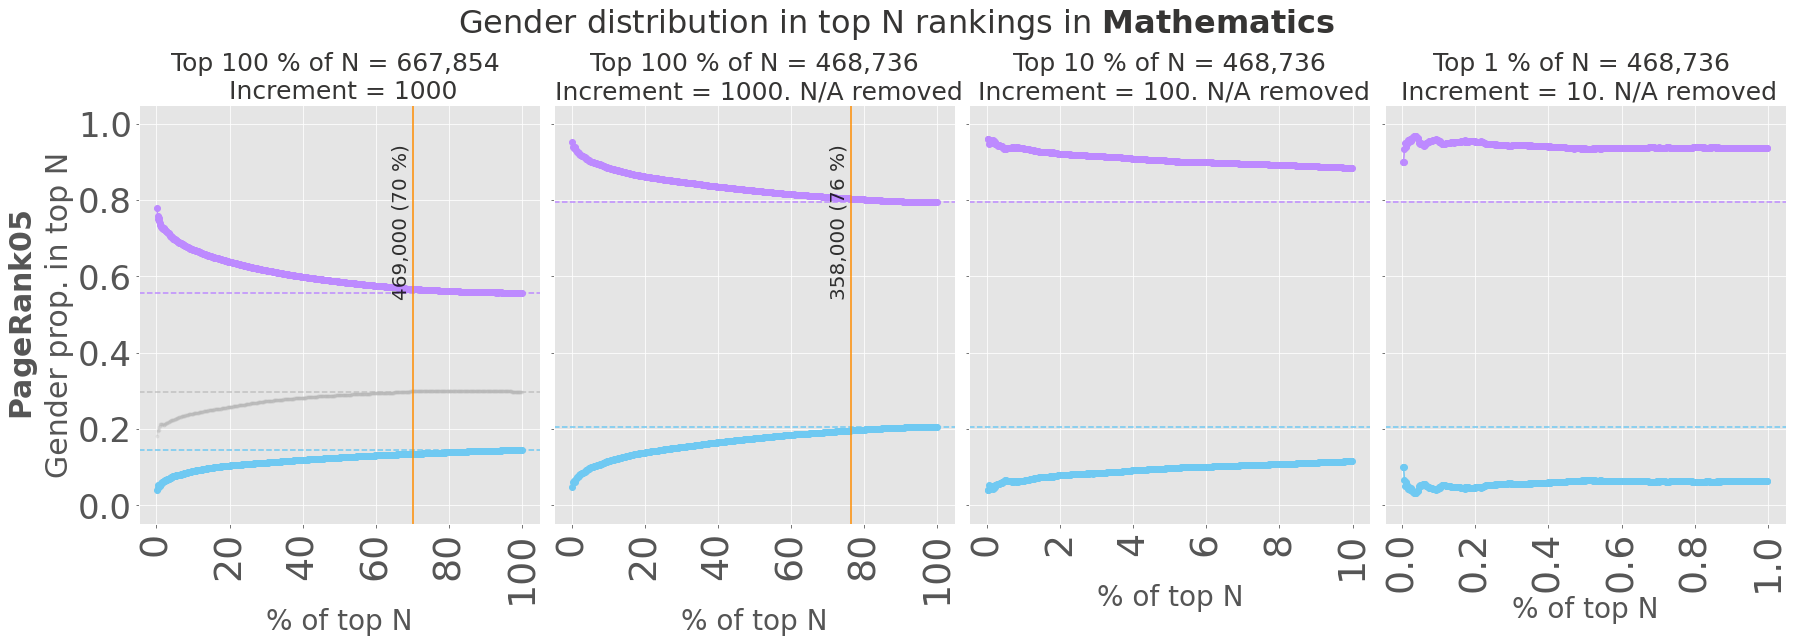

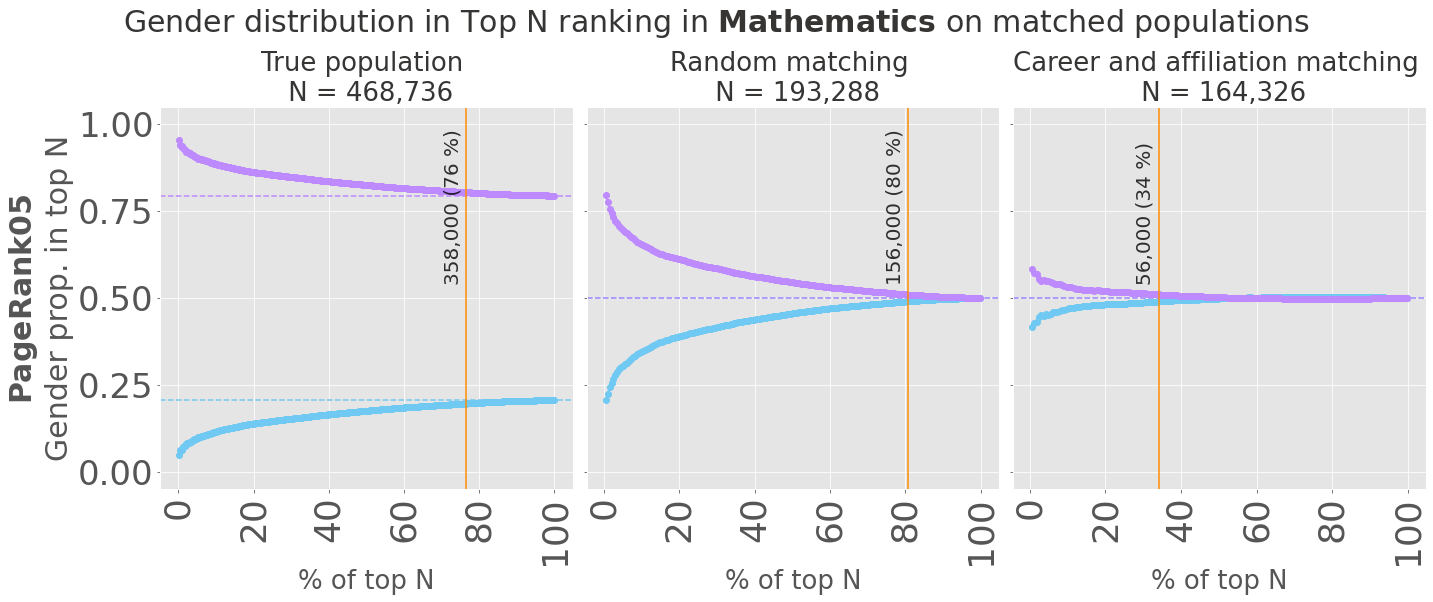

/home/laal/MAG/CentralityFairness/visualizations.py:221: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(xticks, fontsize=labelsize)
/home/laal/MAG/CentralityFairness/visualizations.py:230: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_xticklabels(xticks, fontsize=labelsize)


Full data median: 234367.5
Random data median: 243317.5
Matched data median: 247133.0


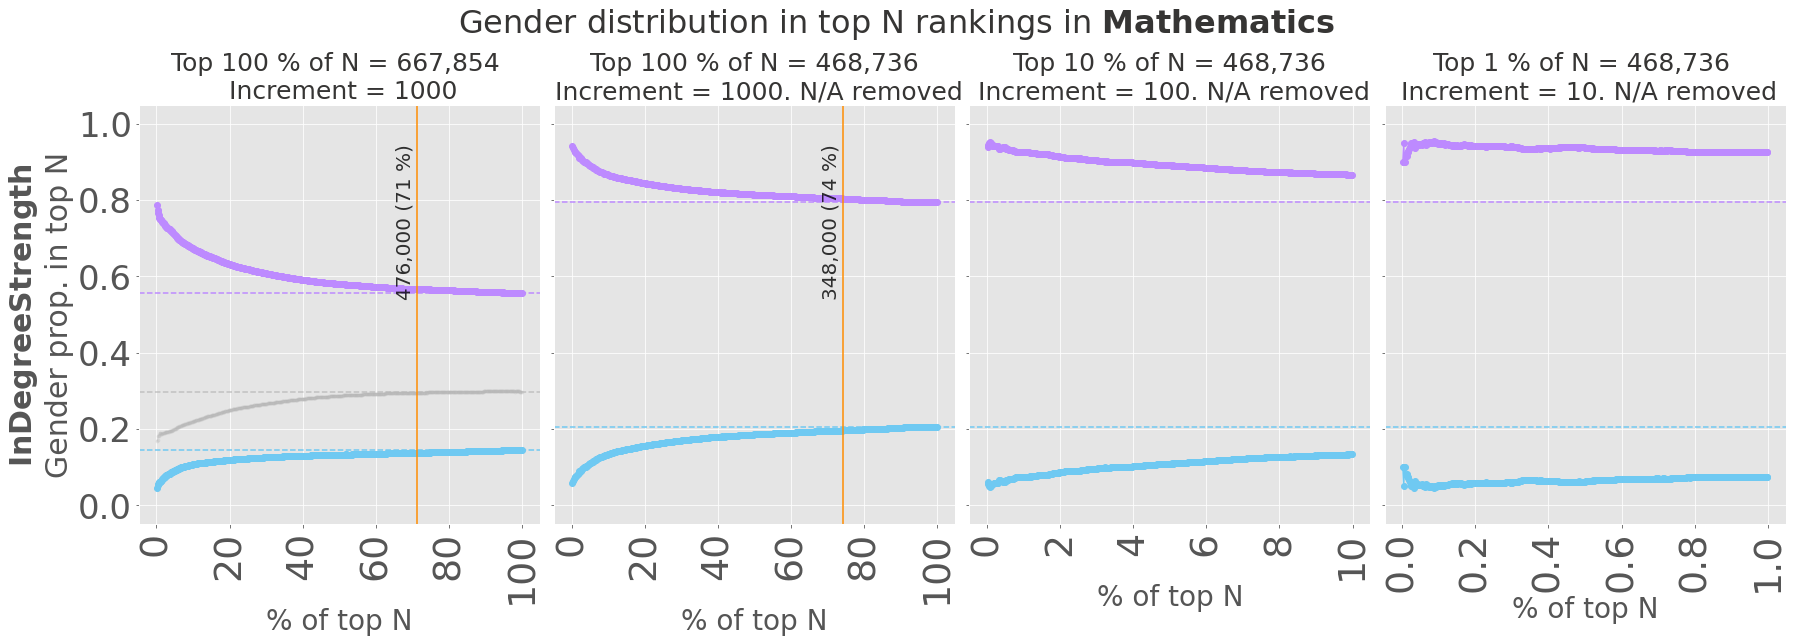

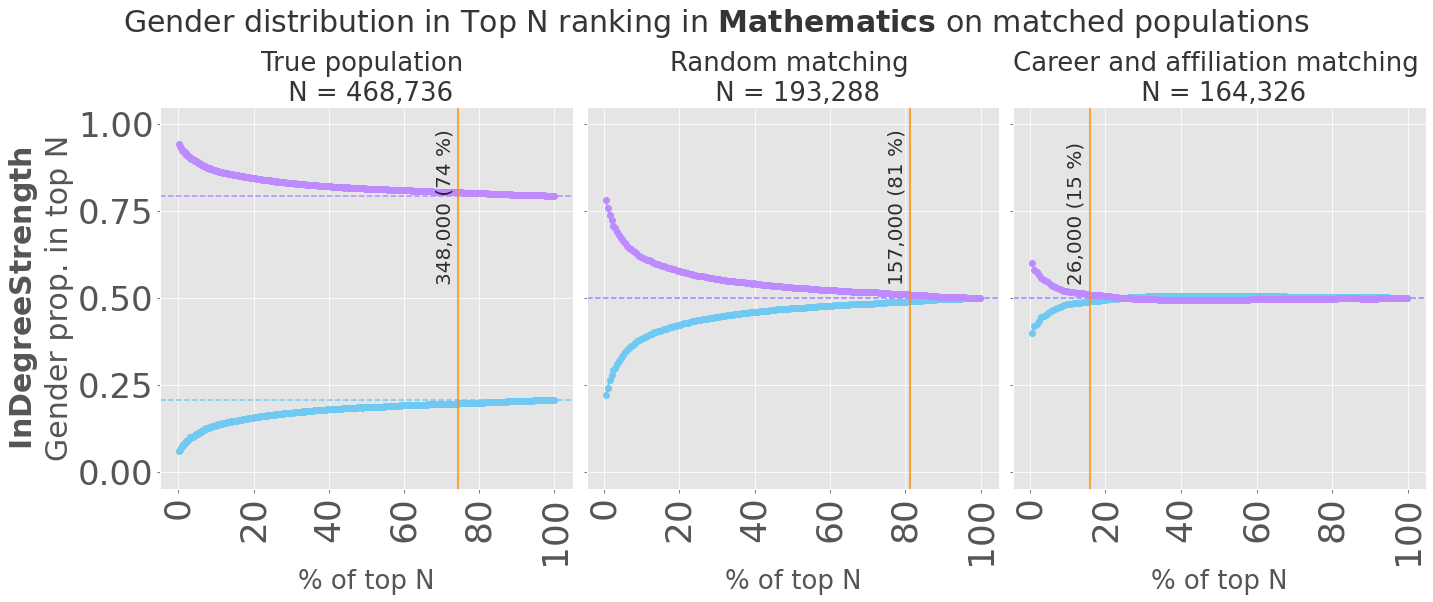

/home/laal/MAG/CentralityFairness/visualizations.py:221: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(xticks, fontsize=labelsize)
/home/laal/MAG/CentralityFairness/visualizations.py:230: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_xticklabels(xticks, fontsize=labelsize)


Full data median: 234367.5
Random data median: 250622.0
Matched data median: 247397.5


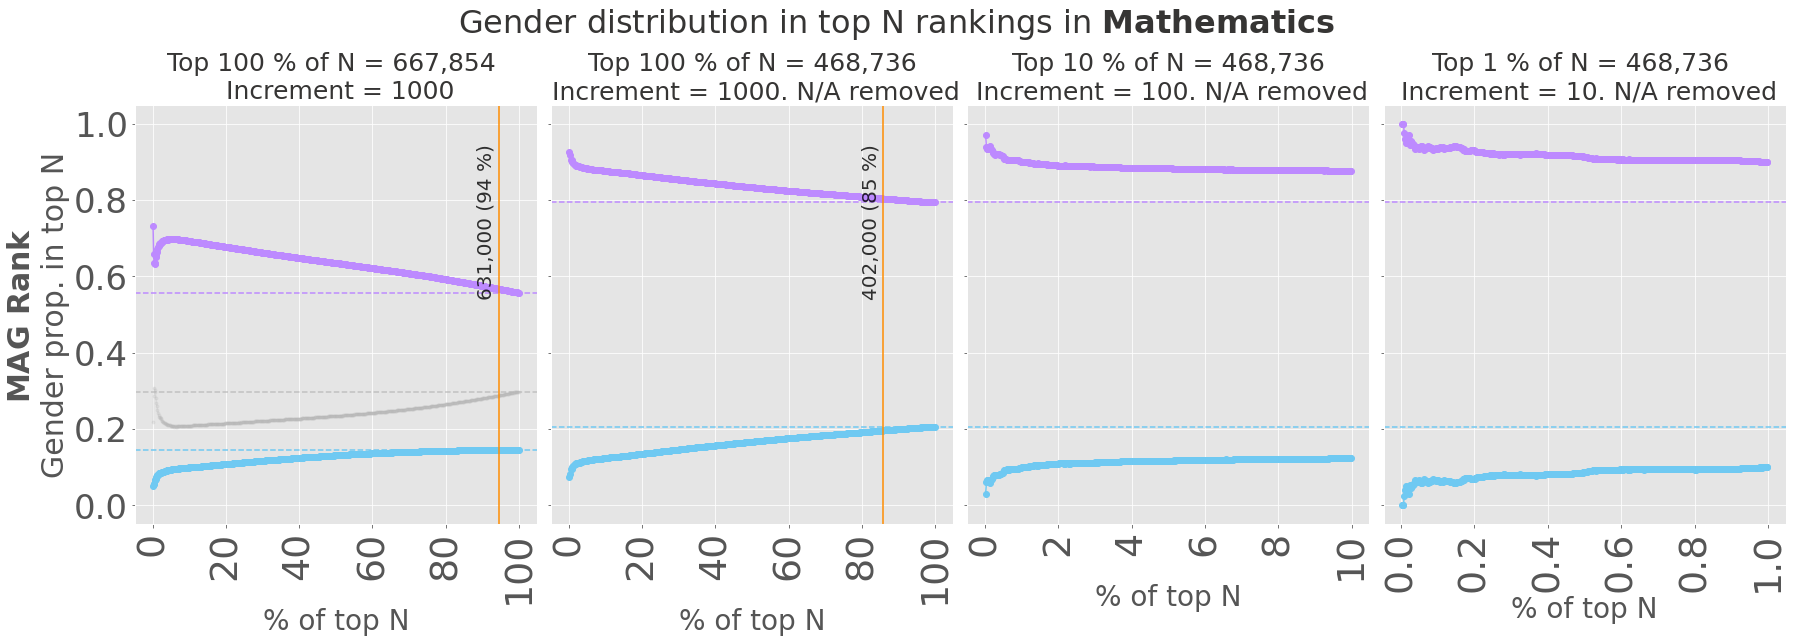

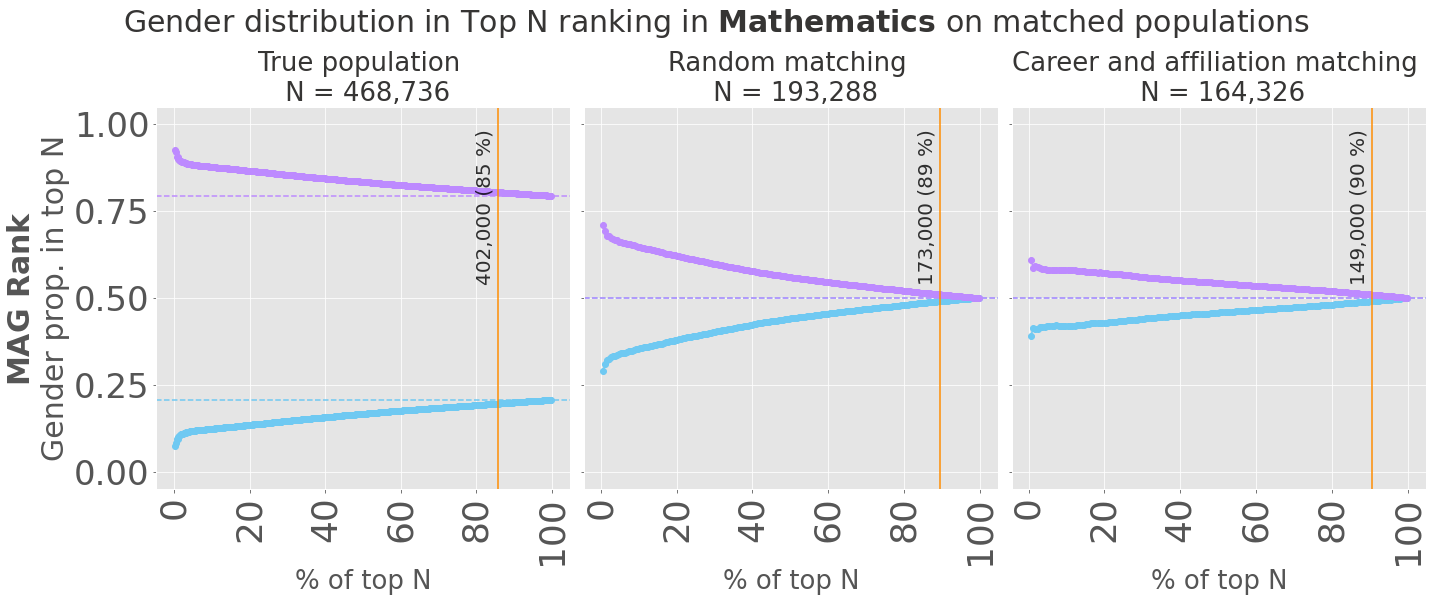

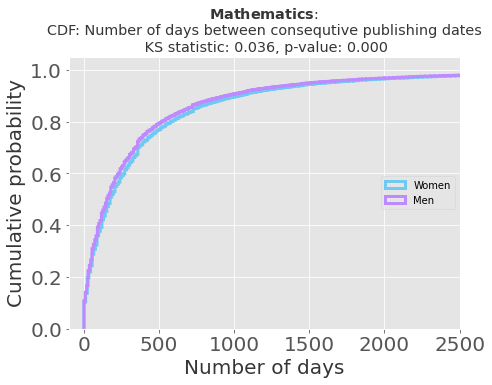

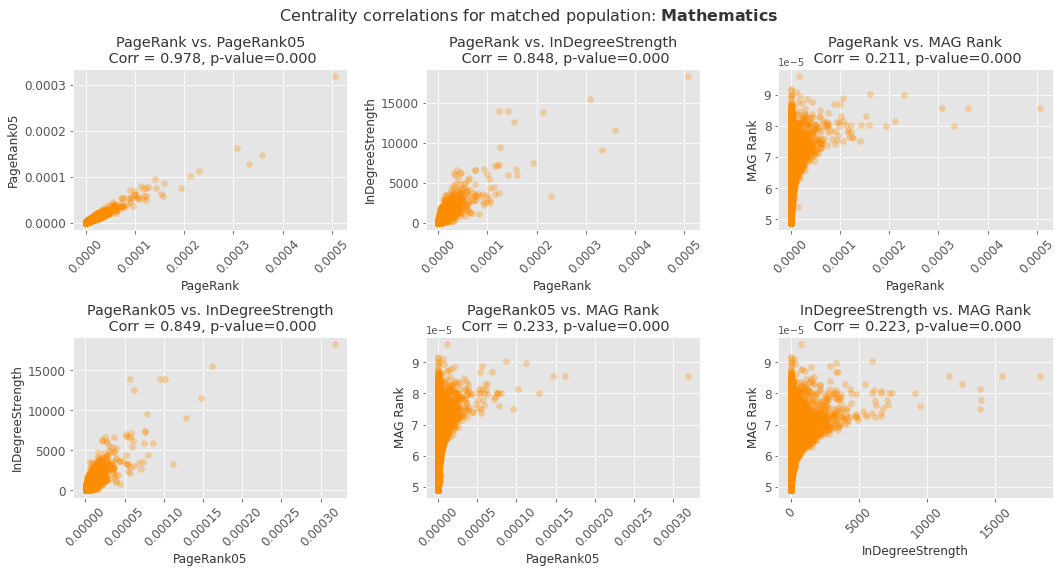

--------------------------------STARTING VIZ ON CHEMISTRY-----------------------------


gender counts before query:

1    2580695
0    1354380
Name: Gender, dtype: int64
Men with more than 1 paper:  (1486013, 12)
Women with more than 1 paper:  (754100, 12)
Number of men before removing NaN-affiliation bin: 1486013
Number of women before removing NaN-affiliation bin: 754100
Number of men after removing NaN-affiliation bin: 1121876
Number of women after removing NaN-affiliation bin: 623413


/home/laal/MAG/CentralityFairness/visualizations.py:221: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(xticks, fontsize=labelsize)
/home/laal/MAG/CentralityFairness/visualizations.py:230: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_xticklabels(xticks, fontsize=labelsize)


Full data median: 1120056.0
Random data median: 1157632.5
Matched data median: 1221613.5


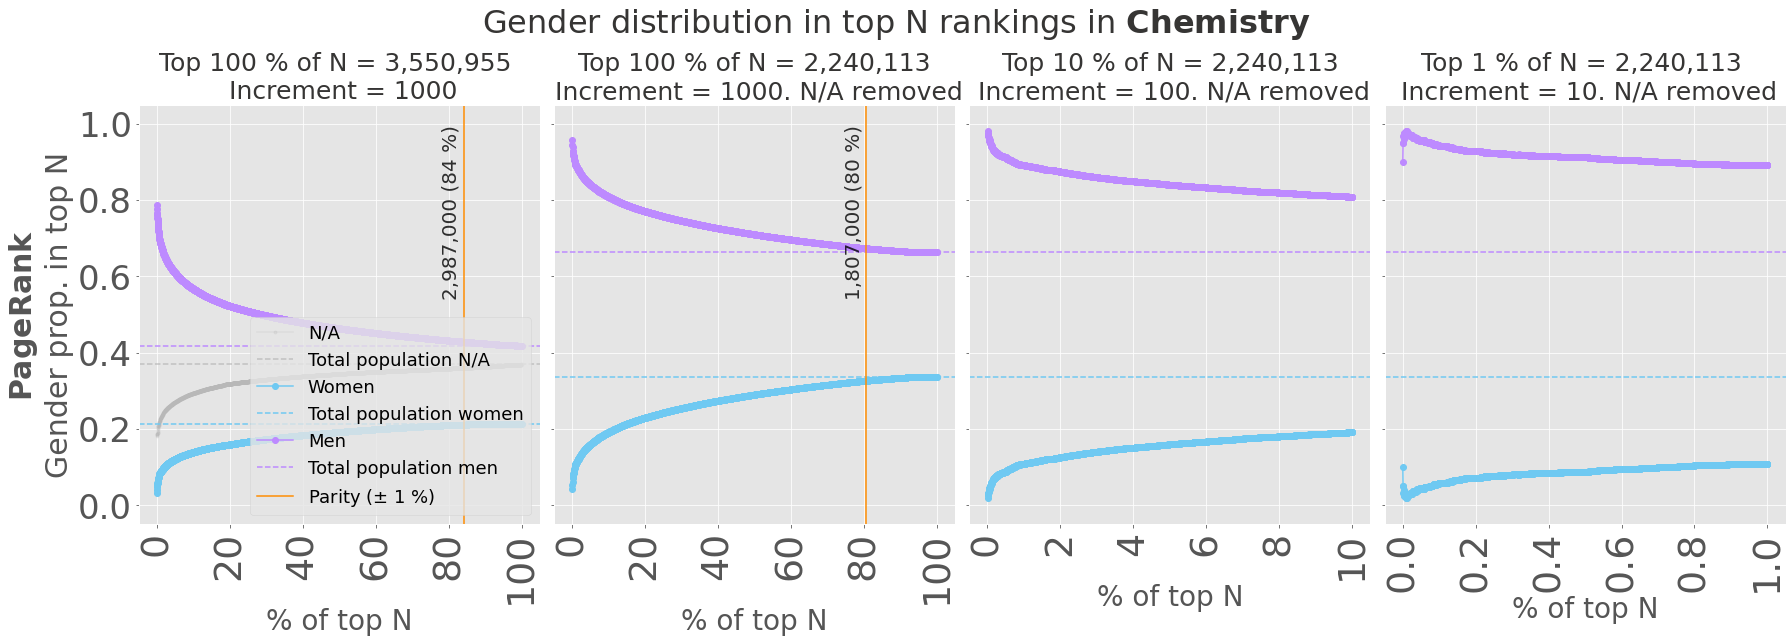

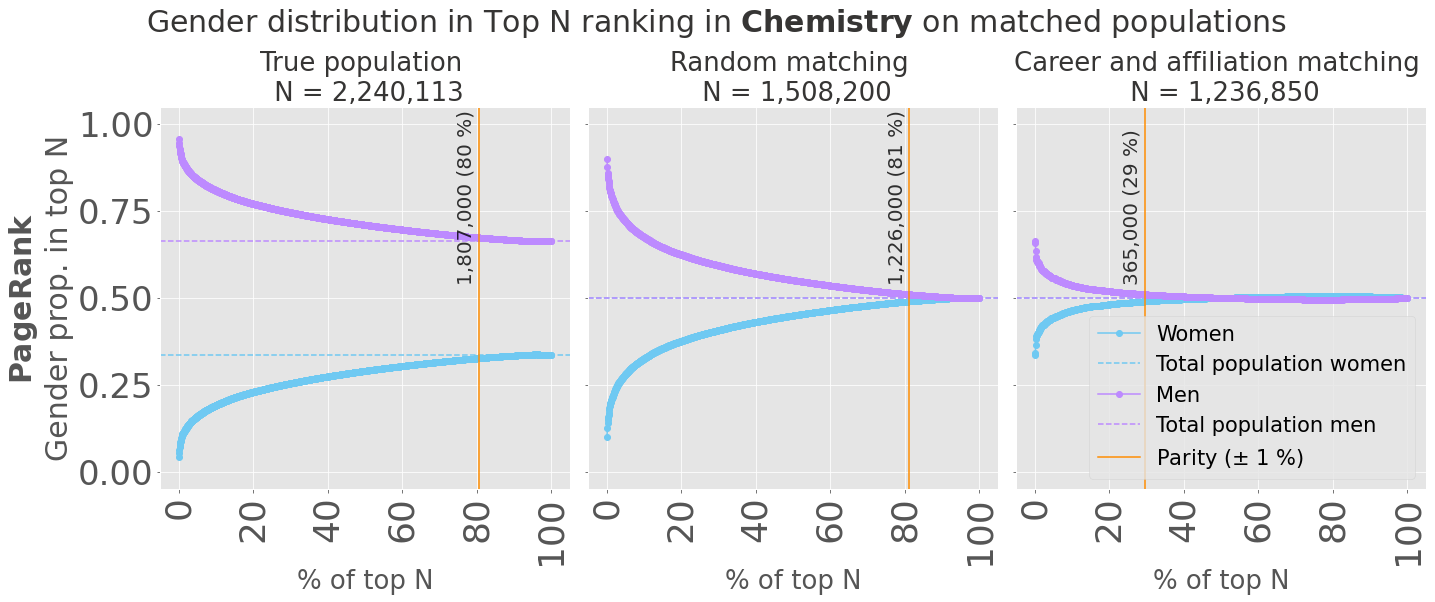

/home/laal/MAG/CentralityFairness/visualizations.py:221: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(xticks, fontsize=labelsize)
/home/laal/MAG/CentralityFairness/visualizations.py:230: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_xticklabels(xticks, fontsize=labelsize)


Full data median: 1120056.0
Random data median: 1155082.5
Matched data median: 1208808.0


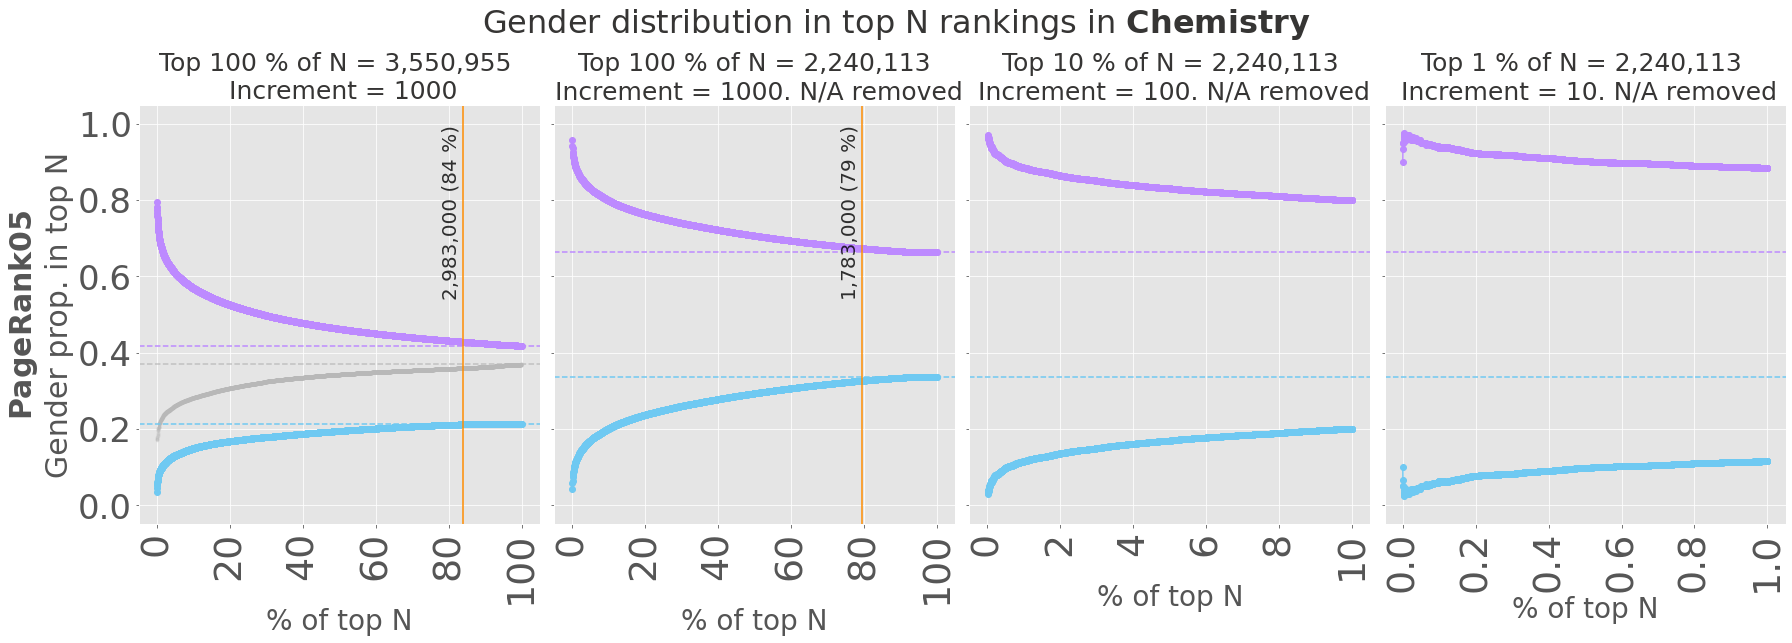

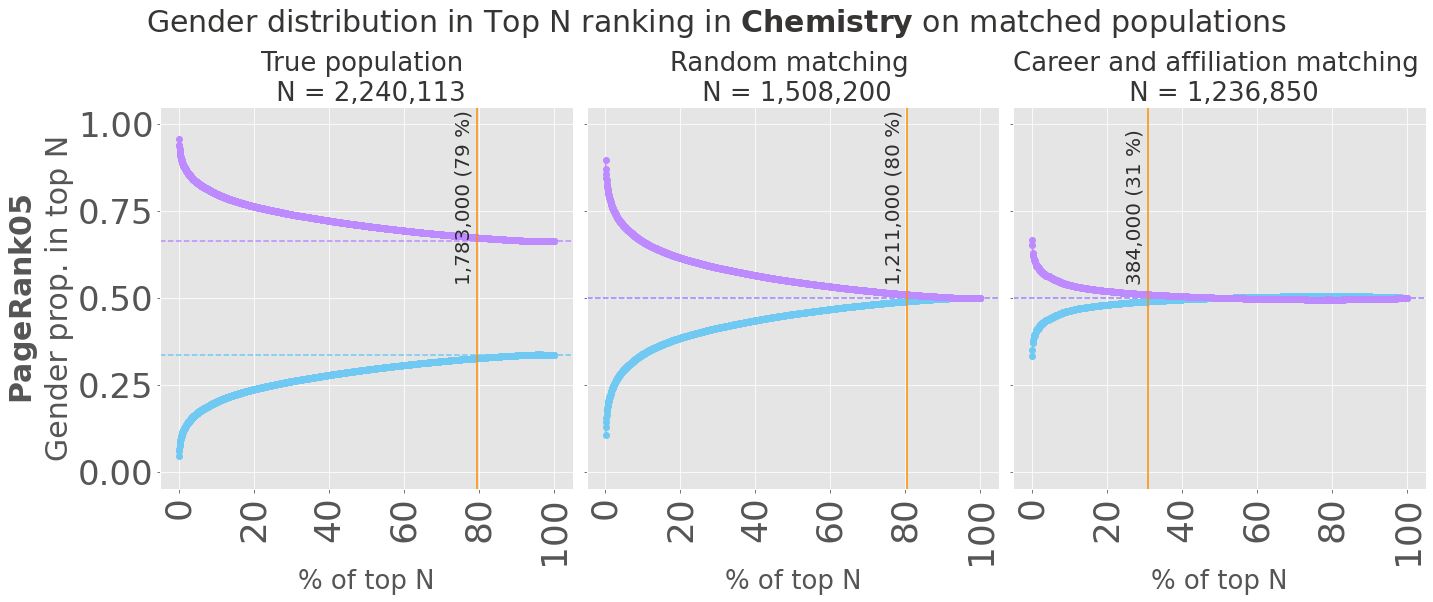

/home/laal/MAG/CentralityFairness/visualizations.py:221: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(xticks, fontsize=labelsize)
/home/laal/MAG/CentralityFairness/visualizations.py:230: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_xticklabels(xticks, fontsize=labelsize)


Full data median: 1120056.0
Random data median: 1136860.0
Matched data median: 1122488.0


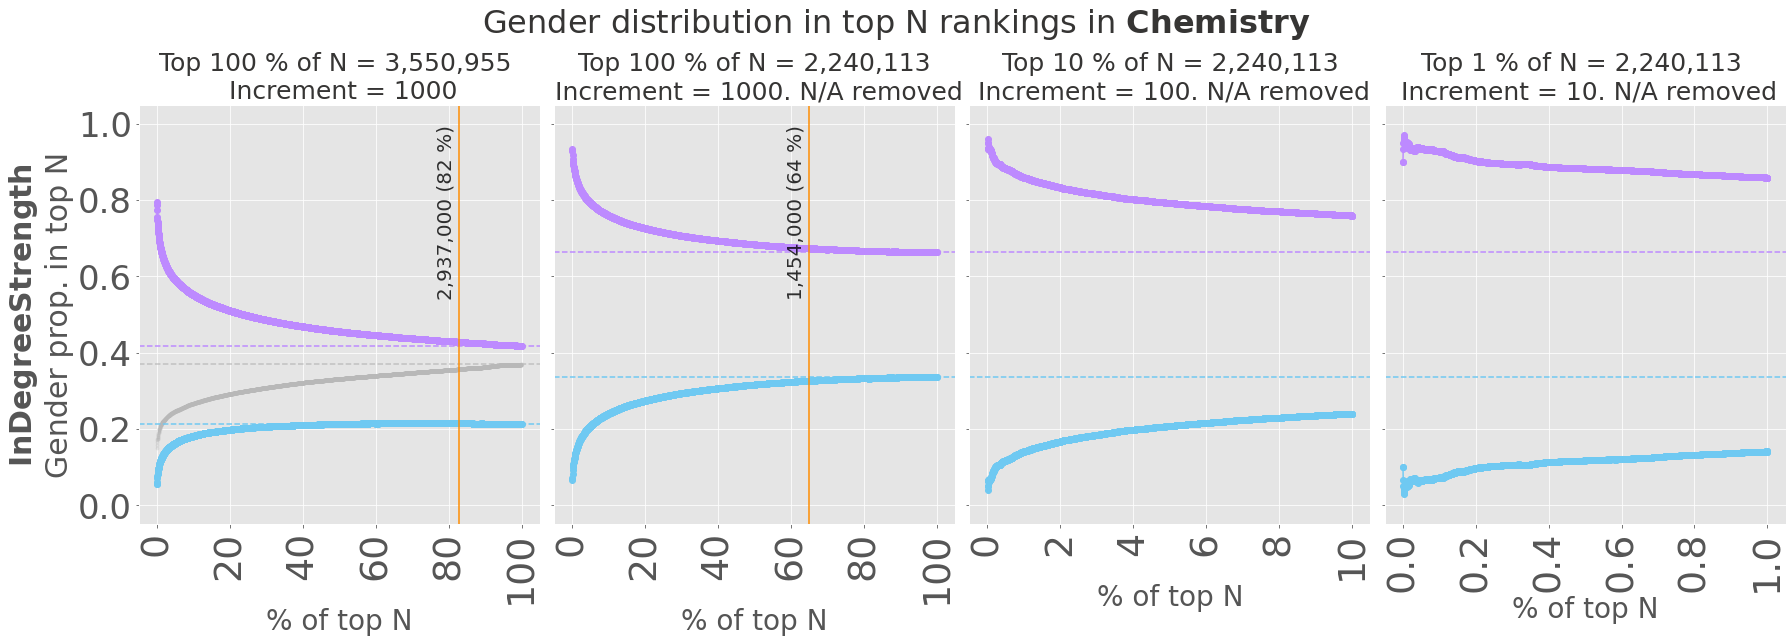

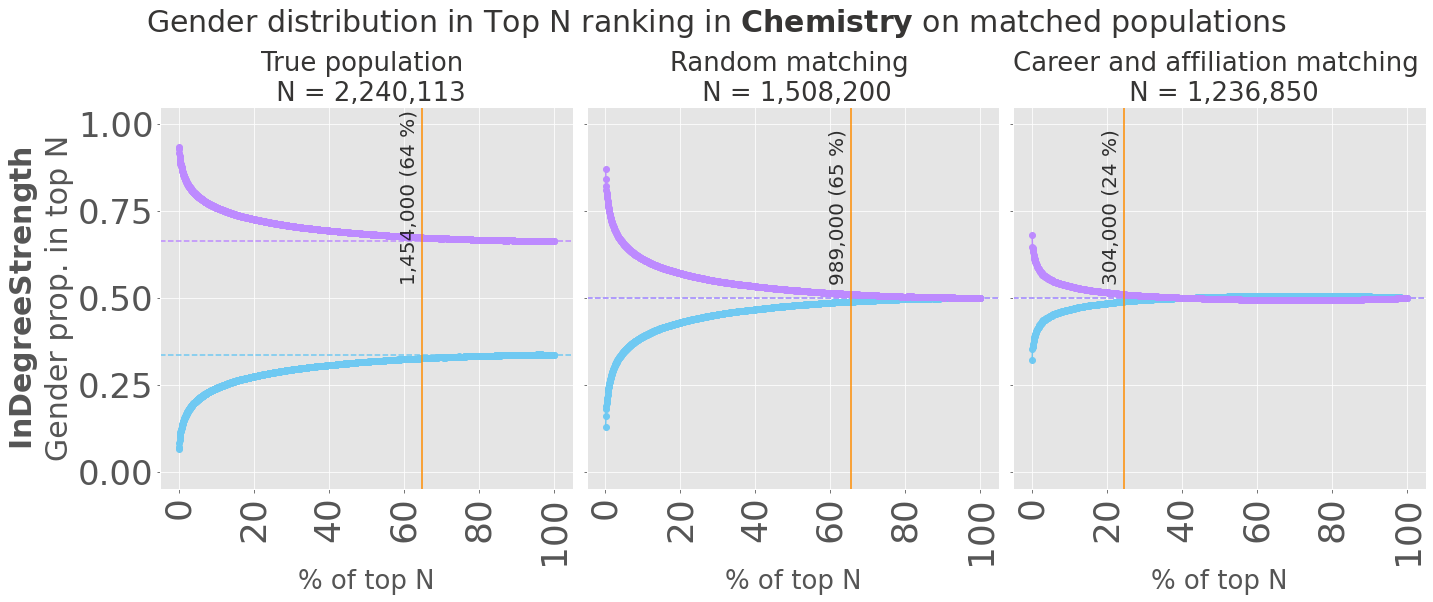

/home/laal/MAG/CentralityFairness/visualizations.py:221: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(xticks, fontsize=labelsize)
/home/laal/MAG/CentralityFairness/visualizations.py:230: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_xticklabels(xticks, fontsize=labelsize)


Full data median: 1120056.0
Random data median: 1155392.5
Matched data median: 1121082.5


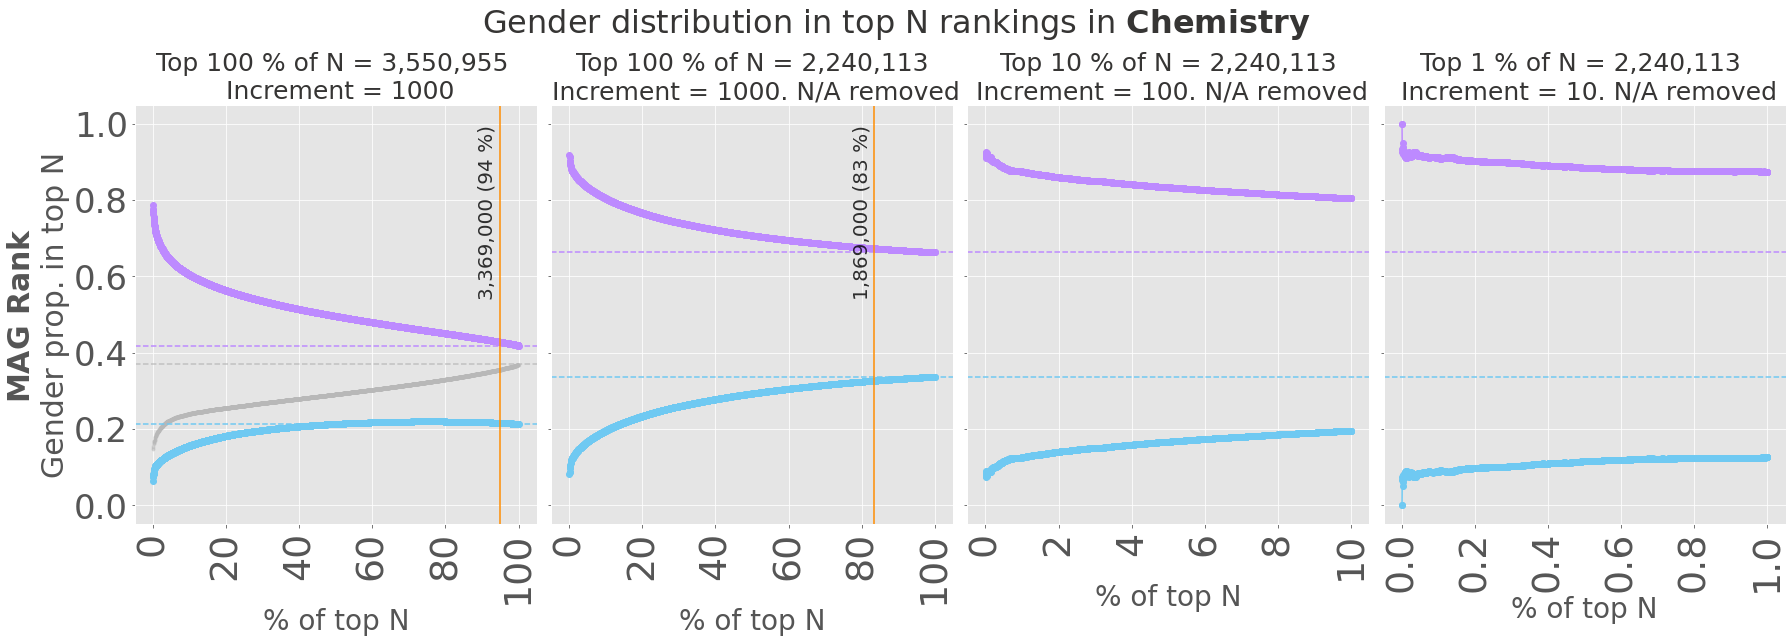

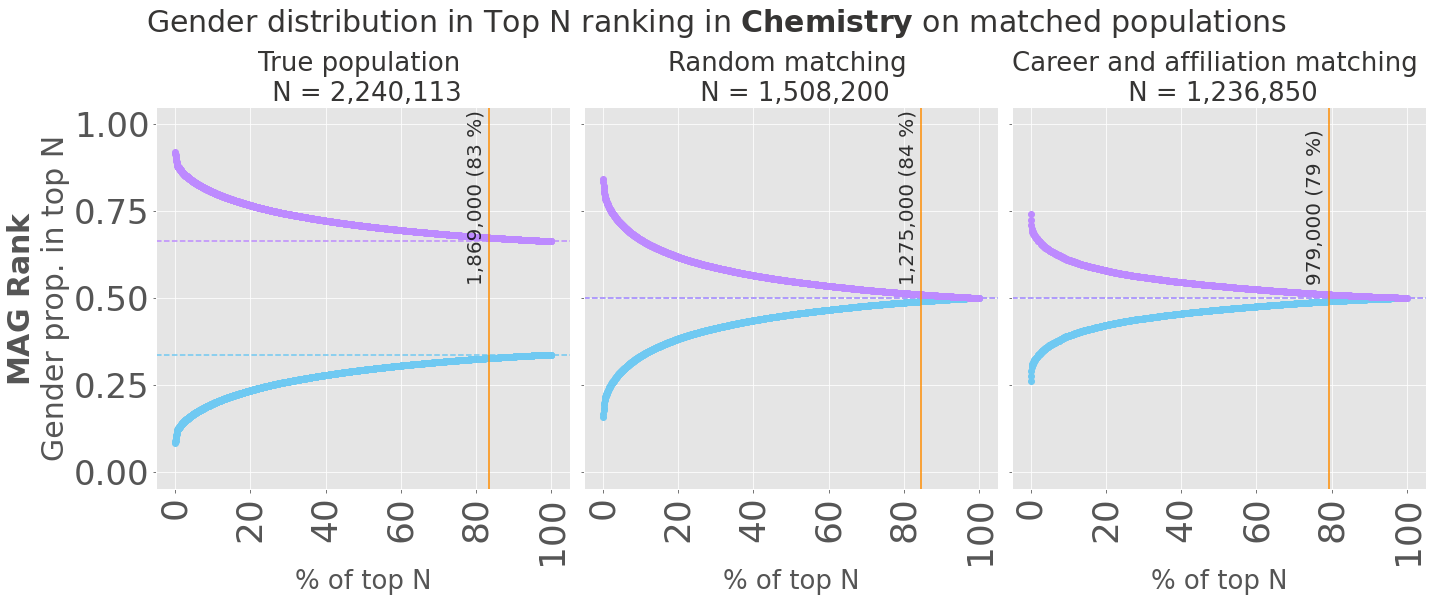

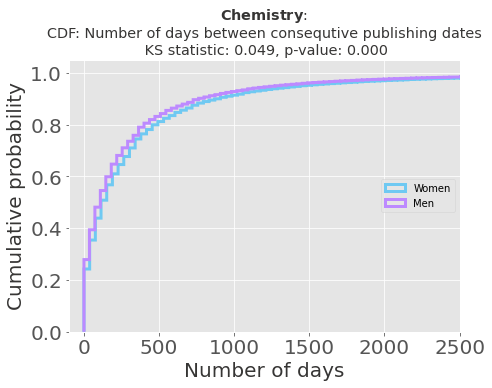

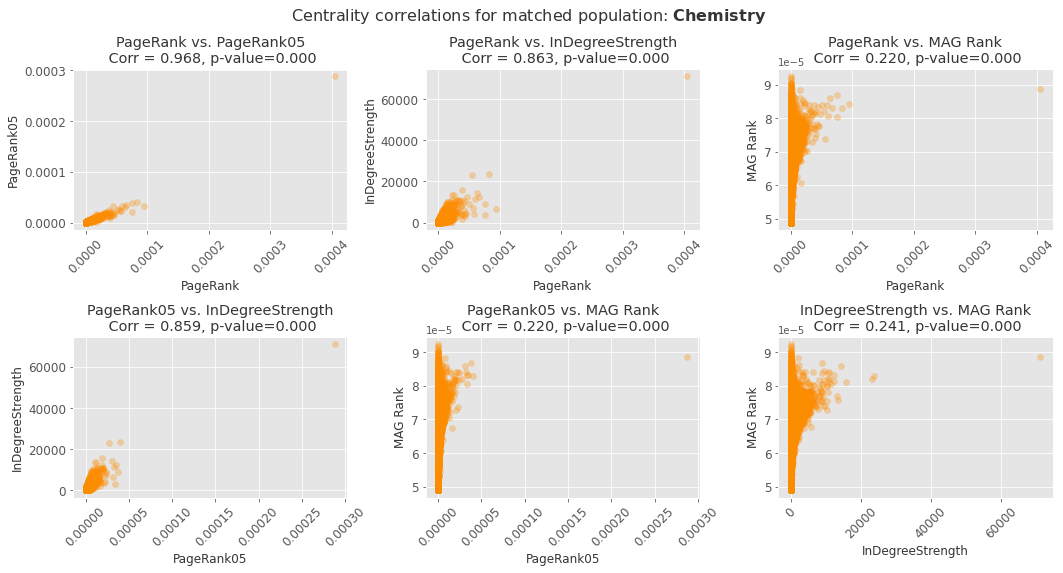

In [4]:
field_ids = {
        "Psychology": 15744967,
        "Economics": 162324750, 
        "Mathematics": 33923547,
        "Chemistry": 185592680,
    }
    
field_mapping = {
        "Economics": "/home/laal/MAG/DATA/NETWORKS/SimpleWeightEconomics2020CentralityGendered.csv", 
        "Psychology": "/home/laal/MAG/DATA/NETWORKS/SimpleWeightPsychology2020CentralityGendered.csv",
        "Mathematics": "/home/laal/MAG/DATA/NETWORKS/SimpleWeightMathematics2020CentralityGendered.csv",
        "Chemistry": "/home/laal/MAG/DATA/NETWORKS/SimpleWeightChemistry2020CentralityGendered.csv",
    }



for field_name, fpath in field_mapping.items():

    file_path = fpath
    field = field_name
    field_id = field_ids[field_name]
    base_filepath = "/home/laal/MAG"
    
    print("--------------------------------STARTING VIZ ON {}-----------------------------\n\n".format(field.upper()))

    destination = base_filepath + "/CentralityFairness/EVALUATIONS_OUTPUTS/matching_repeated_" + field + ".csv"

    seed = 0 if field_name != 'Chemistry' else 1
    
    data = pd.read_csv(file_path, sep="\t")
    matcher = Matcher(centrality_df = data, random_seed=seed, field=field, base_filepath=base_filepath, fos_name=field)
    matcher.load_authors(fos_id=int(field_id), folder_destination = base_filepath + "/DATA/AuthorMetadataField.csv")

    
    male_population = matcher.male_population.sample(frac=1, random_state=matcher.seed).copy()
    female_population = matcher.female_population.sample(frac=1, random_state=matcher.seed).copy()

    print("Number of men before removing NaN-affiliation bin: {}".format(male_population.shape[0]))
    print("Number of women before removing NaN-affiliation bin: {}".format(female_population.shape[0]))

    male_population = male_population[~pd.isnull(male_population.AffiliationBin)]
    female_population = female_population[~pd.isnull(female_population.AffiliationBin)]

    print("Number of men after removing NaN-affiliation bin: {}".format(male_population.shape[0]))
    print("Number of women after removing NaN-affiliation bin: {}".format(female_population.shape[0]))
    

    random_data_males, random_data_females = matcher.random_sample()
    random_data = matcher.samples_to_centrality_data(random_data_males, random_data_females)

    
    #matched_data_males, matched_data_females = matcher.matched_sample()
    #matched_data = matcher.samples_to_centrality_data(matched_data_males, matched_data_females, store=True, is_matched=True)
    
    matched_data = pd.read_csv(base_filepath +  '/CentralityFairness/MATCHING_OUTPUTS/{}_seed{}_matched.csv'.format(field_name, seed), 
                               sep="\t")
    
    
    gendered_pop = pd.concat([matcher.male_population, matcher.female_population])
    unknown_population = matcher.unknown_population

    all_authors = list(gendered_pop.AuthorId.values) + list(unknown_population.AuthorId.values)
    
    centrality_raw = matcher.cent_df_raw[matcher.cent_df_raw.AuthorId.isin(all_authors)]
    
    matcher.save_visualizations(field=field, centrality_df=centrality_raw, random_centrality_df=random_data, 
                                matched_centrality_df=matched_data)
    
    datediffs, ks_test = compute_ks_test(mag, matched_data, fos_id=int(field_id), base_filepath="/home/laal/MAG/DATA")
    
    plot_inter_event_cdf(datediffs, ks_test, field, 
                         filepath=base_filepath +  '/CentralityFairness/EVALUATIONS_PLOTS/' + field + "_interevent_match_visualization.png"
                         )
    
    plot_centrality_correlations(field, matched_data, 
                                 filename=base_filepath +  '/CentralityFairness/EVALUATIONS_PLOTS/' + field + "_centrality_match_visualization.png"
                                )

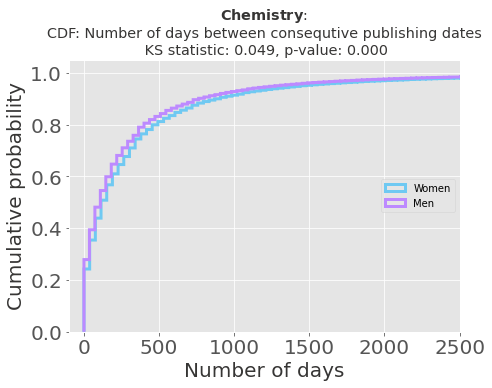

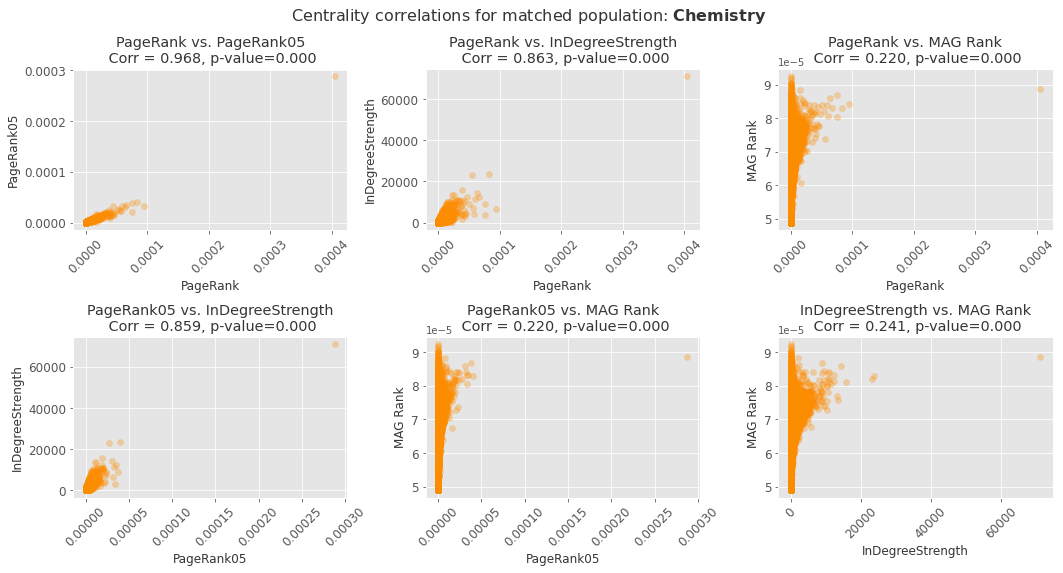

In [5]:
    plot_inter_event_cdf(datediffs, ks_test, field, 
                         filepath=base_filepath +  '/CentralityFairness/EVALUATIONS_PLOTS/' + field + "_interevent_match_visualization.png"
                         )
    
    plot_centrality_correlations(field, matched_data, 
                                 filename=base_filepath +  '/CentralityFairness/EVALUATIONS_PLOTS/' + field + "_centrality_match_visualization.png"
                                )

In [6]:
matched_data

AuthorId      PageRank    PageRank05  InDegreeStrength  InDegree  \
0            233601  2.663048e-08  4.206029e-08          2.250000      33.0   
1            303986  2.914188e-08  4.536002e-08          1.428572      74.0   
2            548035  2.810796e-07  1.536697e-07         57.723423     654.0   
3            765787  1.856844e-08  3.756887e-08          0.000000       0.0   
4           1219248  1.094354e-06  3.964567e-07        114.947220     434.0   
...             ...           ...           ...               ...       ...   
1236845  2764306331  4.996181e-08  7.036135e-08          2.000000      67.0   
1236846  2764321672  3.082306e-08  4.672927e-08          2.589796      55.0   
1236847  2764943992  2.126933e-08  3.958022e-08          1.895238      70.0   
1236848  2765486514  1.979116e-08  3.861836e-08          1.750000      43.0   
1236849  2765708175  1.163089e-07  1.193091e-07         21.527143     347.0   

         OutDegreeStrength  OutDegree  Gender   Rank  MAG Rank  
0                 8.750000       87.0       0  19526  0.000051  
1                 8.390476      200.0       1  18613  0.000054  
2                13.865000      140.0       1  17548  0.000057  
3                 1.818639       83.0       1  15413  0.000065  
4                12.000000       31.0       0  16796  0.000060  
...                    ...        ...     ...    ...       ...  
1236845          18.258333      479.0       0  18812  0.000053  
1236846           6.292517      114.0       0  18364  0.000054  
1236847           9.471380      256.0       0  18748  0.000053  
1236848          21.513855      512.0       1  19675  0.000051  
1236849          38.773335      486.0       1  14285  0.000070  

[1236850 rows x 10 columns]

In [7]:
data.sort_values(by='PageRank', ascending=False, inplace=True)

In [8]:
data.reset_index(inplace=True)

In [9]:
data['rank_position'] = data.index

In [10]:
rank_position_df = data[['AuthorId', 'rank_position']]

In [11]:
matched_data.merge(rank_position_df, how='left', left_on='AuthorId', right_on='AuthorId')['rank_position'].median()

4142976.0

In [12]:
data.query("AuthorId == 599318")

Empty DataFrame
Columns: [index, AuthorId, PageRank, PageRank05, InDegreeStrength, InDegree, OutDegreeStrength, OutDegree, Gender, Rank, rank_position]
Index: []

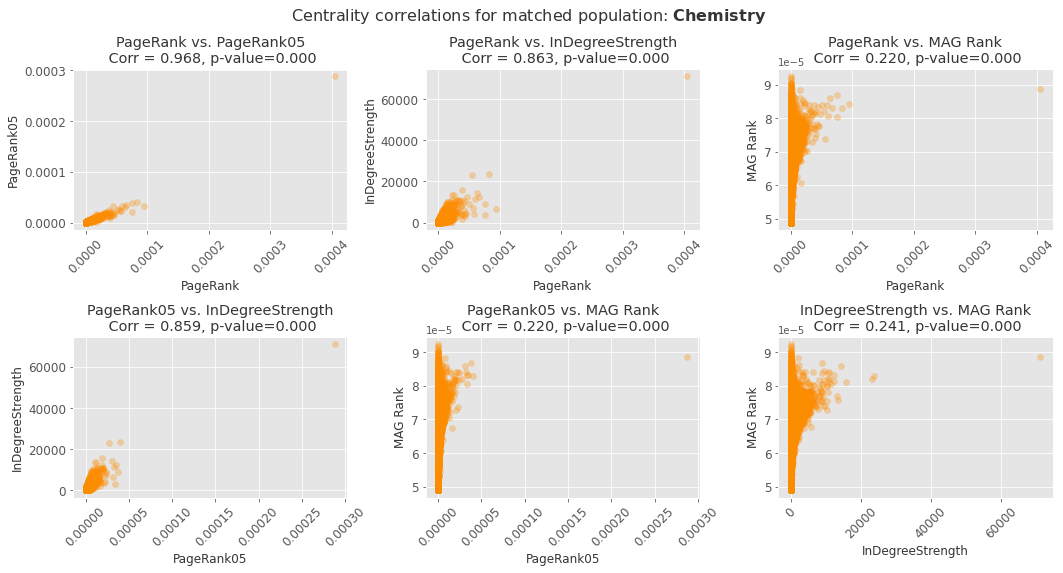

In [13]:
    plot_centrality_correlations(field, matched_data, 
                                 filename=base_filepath +  '/CentralityFairness/EVALUATIONS_PLOTS/' + field + "_centrality_match_visualization.png"
                                )

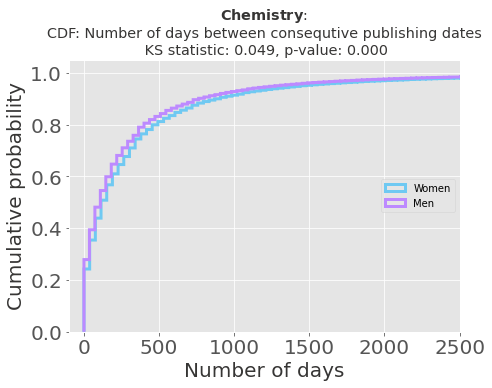

In [14]:
plot_inter_event_cdf(datediffs, ks_test, field, 
                         filepath=base_filepath +  '/CentralityFairness/EVALUATIONS_PLOTS/' + field + "_interevent_match_visualization.png"
                         )

In [15]:
matched_data.head()

AuthorId      PageRank    PageRank05  InDegreeStrength  InDegree  \
0    233601  2.663048e-08  4.206029e-08          2.250000      33.0   
1    303986  2.914188e-08  4.536002e-08          1.428572      74.0   
2    548035  2.810796e-07  1.536697e-07         57.723423     654.0   
3    765787  1.856844e-08  3.756887e-08          0.000000       0.0   
4   1219248  1.094354e-06  3.964567e-07        114.947220     434.0   

   OutDegreeStrength  OutDegree  Gender   Rank  MAG Rank  
0           8.750000       87.0       0  19526  0.000051  
1           8.390476      200.0       1  18613  0.000054  
2          13.865000      140.0       1  17548  0.000057  
3           1.818639       83.0       1  15413  0.000065  
4          12.000000       31.0       0  16796  0.000060

In [16]:
matched_data.corr()

AuthorId  PageRank  PageRank05  InDegreeStrength  InDegree  \
AuthorId           1.000000 -0.034794   -0.035677         -0.051800 -0.073979   
PageRank          -0.034794  1.000000    0.968485          0.862668  0.669155   
PageRank05        -0.035677  0.968485    1.000000          0.858954  0.671542   
InDegreeStrength  -0.051800  0.862668    0.858954          1.000000  0.833684   
InDegree          -0.073979  0.669155    0.671542          0.833684  1.000000   
OutDegreeStrength -0.072159  0.394696    0.378657          0.663183  0.683045   
OutDegree         -0.072817  0.287789    0.298053          0.510947  0.712827   
Gender             0.020454  0.016069    0.014888          0.018782  0.010945   
Rank               0.197120 -0.200687   -0.202139         -0.222456 -0.345400   
MAG Rank          -0.193401  0.220034    0.220274          0.241071  0.364749   

                   OutDegreeStrength  OutDegree    Gender      Rank  MAG Rank  
AuthorId                   -0.072159  -0.072817  0.020454  0.197120 -0.193401  
PageRank                    0.394696   0.287789  0.016069 -0.200687  0.220034  
PageRank05                  0.378657   0.298053  0.014888 -0.202139  0.220274  
InDegreeStrength            0.663183   0.510947  0.018782 -0.222456  0.241071  
InDegree                    0.683045   0.712827  0.010945 -0.345400  0.364749  
OutDegreeStrength           1.000000   0.834258  0.025986 -0.251054  0.263405  
OutDegree                   0.834258   1.000000  0.012922 -0.305689  0.314223  
Gender                      0.025986   0.012922  1.000000 -0.088885  0.091461  
Rank                       -0.251054  -0.305689 -0.088885  1.000000 -0.993715  
MAG Rank                    0.263405   0.314223  0.091461 -0.993715  1.000000

In [17]:
scipy.stats.pearsonr(matched_data['PageRank'], matched_data['InDegreeStrength'])

(0.862668246931624, 0.0)

In [18]:
ks_2samp([1,2,3,4,5], [2,3,4,5,6]).pvalue

1.0

In [19]:
ks_2samp([1,2,3,4,5], [2,3,4,5,6])

KstestResult(statistic=0.2, pvalue=1.0)